# scGen: a landmark generative model for unseen perturbations
---

## 1. Introduction

Single-cell RNA-sequencing (scRNA-seq) has made it possible to measure how thousands of individual cells change their transcriptional programs in response to genetic, chemical, or environmental **perturbations**.  
However, performing every possible perturbation in the wet lab is infeasible; the search space explodes combinatorially, and many experiments are costly or technically difficult.  

**Perturbation‐response models**—such as **scGen**—aim to fill this gap by *predicting* how an unobserved condition would rewrite the transcriptome, given (i) gene-expression data from control cells and (ii) knowledge of a related perturbation. scGen combines a variational autoencoder with latent vector arithmetic to simulate “treated” cells that have never been sequenced. Yet a model is only as good as the evidence supporting it.  

The goal of this notebook is therefore two-fold:
1. **Methodological** – demonstrate a **reproducible benchmarking pipeline** for scGen using the Perturb-Bench toolbox.  
2. **Practical** – show you how to inspect and interpret scGen’s predictions with both **statistical metrics** and **biological read-outs**.

---

### 1.1  What you will learn  

| Step | Key concept | Why it matters |
|------|-------------|----------------|
| **Data loading** | AnnData, metadata harmonisation | Consistent structures make downstream analysis trivial. |
| **Pre-processing** | Normalisation, highly-variable gene (HVG) selection | Removes technical noise and speeds up training. |
| **Model training** | scGen VAE, latent arithmetic | Generates *in silico* perturbations. |
| **Evaluation** | R², Pearson r, logFC overlap, distance metrics | Quantifies how close predictions are to real data. |
| **Biological validation** | Gene regulatory networks, pathway enrichment, marker recovery | Tests whether predictions respect known biology. |

---

### 1.2  Why start with the [*Stephenson 2021*](https://figshare.com/articles/dataset/Stephenson_Covid-19_PBMC_2021_BCR/22132946?file=39347336) dataset?  

*   It provides a clean **control vs LPS** immune-stimulation experiment with well-annotated cell types.  
*   The subsample (~3 k cells) trains quickly on CPU/GPU, making it ideal for a workshop setting.  
*   Its moderate complexity lets us illustrate the full pipeline **without** overwhelming computational cost.

> **Beyond this tutorial**  
> The same workflow generalises to multi-study, cross-species, temporal, or disease-state perturbations—simply swap in a different `pt.data.*` loader or your own `.h5ad` file.

---

### 1.3  Roadmap  

1. **Load & explore data** *(Stephenson 2021, control vs LPS)*  
2. **Pre-process** counts → logCPM, select 2 000 HVGs  
3. **Train scGen** (30 epochs) with reproducible seeds  
4. **Score predictions** using both statistical and biological metrics  
5. **Visualise** true vs predicted log fold-changes  
6. **Save** the trained model and processed dataset for future work

Let’s jump in!

---

## 2. Environment Setup & Imports

In [36]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)

# --- Numerical & data-handling stack ------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics

# --- Single-cell analysis ecosystem -------------------------------------------
import scanpy as sc       # core single-cell workflow (AnnData, QC, plotting)
import pertpy as pt       # Perturb-Bench helpers: dataset loaders & metrics
from scvi import REGISTRY_KEYS  # keys used by scvi-tools / scGen for AnnData metadata

# --- Deep-learning backend -----------------------------------------------------
import torch              # PyTorch (Tensor operations and GPU acceleration)

# --- Machine-learning utilities ----------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.linear_model import LogisticRegression  # classifier used in metrics
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import (
    pairwise_distances,   # generic distance matrix
    silhouette_score,     # clustering quality
    roc_auc_score         # AUROC for binary classification tasks
)

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # base plotting library
import seaborn as sns            # higher-level statistical plots

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True   # exact determinism (may reduce speed)
torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}")

Random seed set to 42


---

## 3. Data Exploration & Preparation

### 3.1 Loading and Exploring the *Stephenson 2021* dataset

We begin by loading a subsampled version of the *Stephenson 2021* dataset that will be used throughout this notebook.

In [37]:
# adata = pt.data.stephenson_2021_subsampled() # loading the data by downloading the file
adata = sc.read('data/stephenson_2021_subsampled.h5ad') # loading the data directly from the file

adata # viewing the data

AnnData object with n_obs × n_vars = 62509 × 16299
    obs: 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'
    uns: 'log1p', 'umap'
    obsm: 'X_scVI', 'X_umap'

[`AnnData`](https://anndata.readthedocs.io/) is the de-facto container for single-cell data in Python (used by **Scanpy**, **scvi-tools**, **Perturb-Bench**, and many other packages). Think of it as a tidy “Excel workbook” with one big table of gene expression and several *linked* annotation sheets:

| Attribute | Purpose | In our dataset |
|-----------|---------|----------------|
| **`.X`** *(n_obs × n_vars)* | The main numerical matrix – usually raw counts, log-counts, or latent embeddings. Rows = **cells** (*observations*), columns = **genes** (*variables*). | 62,509 cells (drawn from peripheral blood mononuclear cells (PBMCs)) × 16,299 genes (log-normalised counts, after basic filtering by the original authors). |
| **`.obs`** | Per-cell metadata (pandas `DataFrame`). | 21 columns – e.g. `cell_type`, `time_after_LPS`, `patient_id`, `Status` (control, Covid, LPS). |
| **`.var`** | Per-gene metadata. | `gene_id`, `gene_name`. |
| **`.layers`** | Alternative expressions of `.X` (raw counts, denoised counts, predictions …). | Empty for now – we’ll add `counts` and `corrected` later. |
| **`.uns`** | Unstructured info: colour maps, model parameters, etc. | Contains Scanpy’s `log1p` settings and pre-computed UMAP. |
| **`.obsm` / `.varm`** | Multi-dimensional annotations (matrices): embeddings, feature scores. | `X_umap` (2-D UMAP) and `X_scVI` (latent space). |
| **`.obsp` / `.varp`** | Pairwise matrices (graphs, distances). | Not present yet. |

In [38]:
adata.obs.head(10)  # viewing the first 10 rows of the observation metadata (cell-level)

,Collection_Day,Swab_result,Status,Smoker,Status_on_day_collection,Status_on_day_collection_summary,Days_from_onset,Site,time_after_LPS,Worst_Clinical_Status,...,patient_id,author_cell_type,organism,sex,tissue,ethnicity,disease,assay,cell_type,dataset_group
10_1038_s41591_021_01329_2-S11_GAGTCCGGTTCAGGCC-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD4.Tfh,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,T follicular helper cell,P
10_1038_s41591_021_01329_2-S12_ACTGTCCTCTCGTATT-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD4.CM,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"central memory CD4-positive, alpha-beta T cell",P
10_1038_s41591_021_01329_2-S12_CTCTAATAGTTTCCTT-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,NK_16hi,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"CD16-positive, CD56-dim natural killer cell, h...",P
10_1038_s41591_021_01329_2-S12_GCATACAGTAATCGTC-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD8.Naive,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"naive thymus-derived CD8-positive, alpha-beta ...",P
10_1038_s41591_021_01329_2-S12_GACTGCGTCCTTTCGG-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,NK_16hi,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"CD16-positive, CD56-dim natural killer cell, h...",P
10_1038_s41591_021_01329_2-S11_CAAGGCCAGGGATGGG-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD14_mono,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,CD14-positive monocyte,P
10_1038_s41591_021_01329_2-S11_CGGTTAATCGGATGGA-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD8.EM,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"effector memory CD8-positive, alpha-beta T cell",P
10_1038_s41591_021_01329_2-S11_GATCTAGTCACTATTC-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,B_naive,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,naive B cell,P
10_1038_s41591_021_01329_2-S11_CATGACAAGGTGCACA-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,CD4.CM,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,"central memory CD4-positive, alpha-beta T cell",P
10_1038_s41591_021_01329_2-S12_CTCGGAGTCCGTTGCT-1,D0,Positive,Covid,Smoker,ITU_NIV,Severe,28,Sanger,nan,nan,...,AP1,gdT,Homo sapiens,male,blood,unknown,COVID-19,10x 3' transcription profiling,gamma-delta T cell,P


In [39]:
adata.var.head(10)  # viewing the first 10 rows of the variable metadata (gene-level)

,gene_id,gene_name
FAM87B,ENSG00000177757,FAM87B
LINC00115,ENSG00000225880,LINC00115
FAM41C,ENSG00000230368,FAM41C
SAMD11,ENSG00000187634,SAMD11
NOC2L,ENSG00000188976,NOC2L
KLHL17,ENSG00000187961,KLHL17
PLEKHN1,ENSG00000187583,PLEKHN1
PERM1,ENSG00000187642,PERM1
HES4,ENSG00000188290,HES4
ISG15,ENSG00000187608,ISG15


---

### 3.2 Preparing the *Stephenson 2021* dataset for scGen

Key `.obs` columns you will use in this tutorial:
| Column | Description |
|--------|-------------|
| `cell_type` | High-level cell type annotation (e.g. CD14⁺ monocyte, CD4⁺ T cell) |
| `Status` | Experimental condition: control (untreated) or LPS (lipopolysaccharide-stimulated) |
| `patient_id` | Patient identifier (useful for batch correction / cross-validation) | 
| `time_after_LPS` | Hours since LPS stimulation (continuous covariate) |

In [40]:
display(adata.obs['Status'].value_counts())  # counting the number of cells in each condition

Status
Covid      48083
Healthy    11790
LPS         2636
Name: count, dtype: int64

For the purpose of this tutorial, we will further downsample the dataset to 13,000 cells, which is a manageable size for training scGen on a standard laptop.

In [41]:
# ------------------------------------------------------------------
# Sub-sample to 13 000 cells while preserving the Status proportions
# ------------------------------------------------------------------
target_total = 13_000                     # final size
status_col   = "Status"                   # column with the class labels
rng          = SEED                       # for reproducibility

# 1) Desired sample size per class (rounded)
status_counts  = adata.obs[status_col].value_counts()
target_counts  = (
    (status_counts / status_counts.sum()) * target_total
).round().astype(int)

# 2) Make sure rounding still sums to target_total
diff = target_total - target_counts.sum()
if diff != 0:                        # add/subtract the remainder to the largest class
    largest = target_counts.idxmax()
    target_counts[largest] += diff

print("Sampling plan:\n", target_counts.to_string(), "\n")

# 3) Collect indices stratified by Status
idx_list = []
for status, n in target_counts.items():
    idx = (
        adata.obs.query(f"{status_col} == @status")
        .sample(n, random_state=rng)
        .index
    )
    idx_list.append(idx)

subset_idx = np.concatenate(idx_list)

# 4) Create the down-sampled AnnData object
adata_sub = adata[subset_idx].copy()

# 5) Sanity-check the new distribution
display(adata_sub.obs[status_col].value_counts())

print(f"\nFinal shape: {adata_sub.n_obs:,} cells × {adata_sub.n_vars:,} genes")

Sampling plan:
 Status
Covid      10000
Healthy     2452
LPS          548 



Status
Covid      10000
Healthy     2452
LPS          548
Name: count, dtype: int64


Final shape: 13,000 cells × 16,299 genes


For this tutorial, we will focus on the `Status` column to compare **control vs LPS-stimulated cells** and figure out how well scGen can predict the transcriptional changes induced by LPS treatment.

In [42]:
norm_data = adata_sub[adata_sub.obs["Status"] != "Covid"] # filtering out COVID cells

norm_data # viewing the normal data (non-COVID cells)

View of AnnData object with n_obs × n_vars = 3000 × 16299
    obs: 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'
    uns: 'log1p', 'umap'
    obsm: 'X_scVI', 'X_umap'

In [43]:
display(norm_data.obs['Status'].value_counts())  # counting the number of cells per status in the normal data

Status
Healthy    2452
LPS         548
Name: count, dtype: int64

We then create a subset of our subsampled dataset that contains only the top 5 most abundant cell types, which will help us focus on the most relevant biological signals and reduce computational complexity.

In [44]:
# 1) Subset to top-5 cell types
counts = norm_data.obs["cell_type"].value_counts()
top5   = counts.head(5).index.tolist()

# 2) Subset the AnnData
norm_data_qc = norm_data[norm_data.obs["cell_type"].isin(top5)].copy()

# 3) Verify
print("Kept cell counts:")
display(norm_data_qc.obs["cell_type"].value_counts())

Kept cell counts:


cell_type
CD16-positive, CD56-dim natural killer cell, human      445
naive thymus-derived CD4-positive, alpha-beta T cell    370
naive B cell                                            274
CD14-positive monocyte                                  252
naive thymus-derived CD8-positive, alpha-beta T cell    247
Name: count, dtype: int64

In [45]:
display(norm_data_qc.obs['Status'].value_counts()) # counting the number of cells per status in the normal data after QC

Status
Healthy    1229
LPS         359
Name: count, dtype: int64

We then proceed to filter out low-quality cells based on the number of genes expressed and the total counts, ensuring that we retain only high-quality cells for training.

Finally, we will normalise the data using logCPM (counts per million) and select the top 2,000 highly variable genes (HVGs) to speed up training and focus on the most informative features.

In [51]:
norm_data_qc_hvg = norm_data_qc.copy() # creating a copy of the AnnData object for highly variable genes (HVG) analysis


sc.pp.highly_variable_genes(
    norm_data_qc_hvg,
    n_top_genes=2000,
    flavor="seurat",
    subset=True
)

norm_data_qc_hvg # viewing the AnnData object after HVG selection

AnnData object with n_obs × n_vars = 1588 × 2000
    obs: 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap'

We can also plot the UMAP of the filtered dataset to visualise the cell types and their distribution in the latent space.

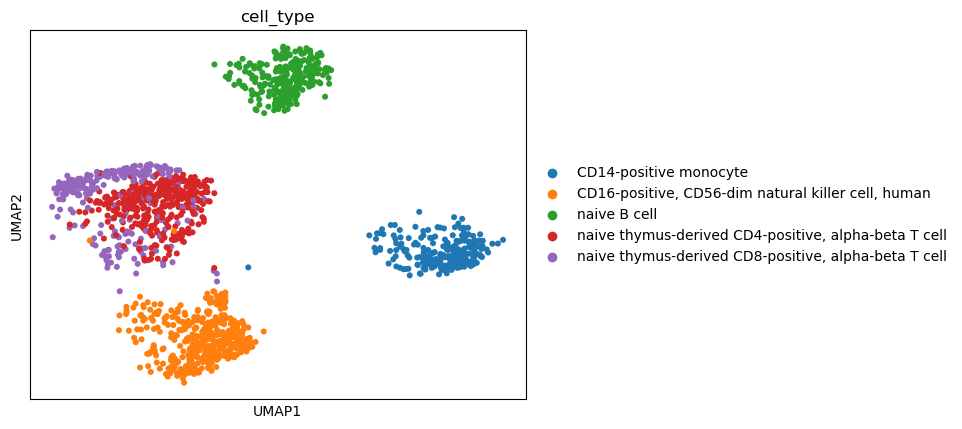

In [52]:
sc.pl.umap(norm_data_qc_hvg, color = "cell_type")

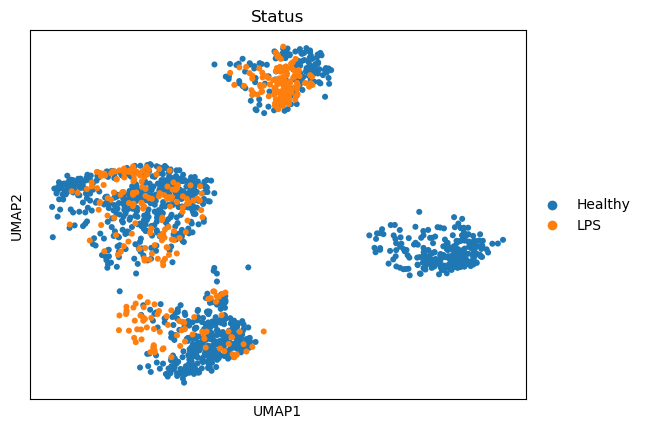

In [53]:
sc.pl.umap(norm_data_qc_hvg, color = "Status")

Finally, before proceeding with the training, we will rename the `.obs` columns to match the expected format for scGen:
* The 'Status' column will be renamed to 'label', where:
  * Control cells will be designated as "ctrl"
  * LPS-stimulated cells will be designated as "stim"

In [55]:
# Perturbation column
norm_data_qc_hvg.obs.rename(columns={"Status": "label"}, inplace=True)

norm_data_qc_hvg

AnnData object with n_obs × n_vars = 1588 × 2000
    obs: 'Collection_Day', 'Swab_result', 'label', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'umap', 'hvg', 'cell_type_colors', 'Status_colors'
    obsm: 'X_scVI', 'X_umap'

In [58]:
# Change the name of control and perturbed cells
norm_data_qc_hvg.obs["label"] = norm_data_qc_hvg.obs["label"].cat.rename_categories({"Healthy": "ctrl", "LPS": "stim"})

display(norm_data_qc_hvg.obs["label"].value_counts())  # counting the number of cells per label

label
ctrl    1229
stim     359
Name: count, dtype: int64

---

## 4. Training `scGen`

We first need to select the device to use for training. If you have a GPU available, it will significantly speed up the training process. Otherwise, you can run it on CPU, but it will take longer.

In [30]:
# ── Device selection ─────────────────────────────────────────────────────────
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")

print(
    f"Running on {'GPU' if cuda_available else 'CPU'} – "
    f"{torch.cuda.get_device_name(0) if cuda_available else 'no CUDA device detected'}"
)

Running on CPU – no CUDA device detected


In [36]:
# === CONFIGURATION ===
USE_CSR = True           # feature flag: cast to CSR for speed
K = 100                  # how many top DEGs to compare

# Create figures directory and configure Scanpy
# os.makedirs("figures", exist_ok=True)
# sc.settings.figdir = "figures"

# # Load and subset dataset
# train = pt.dt.kang_2018()
# train.raw = train.copy()
# sc.pp.normalize_total(train)
# norm_data = train

# downsample
target_cells = 1500
idx = np.random.choice(norm_data.obs_names, size=target_cells, replace=False)
norm_data = norm_data[idx].copy()

# Optionally cast to CSR for faster indexing
if USE_CSR and sparse.issparse(norm_data.X):
    norm_data.X = norm_data.X.tocsr()

celltype_col = "cell_type"


# === Metric helpers ===
def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.vstack([m1, v1]).T, np.vstack([m2, v2]).T
    mins, maxs = np.minimum(pts1.min(0), pts2.min(0)), np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.vstack(np.meshgrid(xs, ys)).reshape(2, -1).T
    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca_coords, n_boot=100, frac=0.8, seed=0):
    rng = np.random.default_rng(seed)
    r_idx = np.where(real_mask)[0]
    p_idx = np.where(pred_mask)[0]
    s_r, s_p = max(1, int(frac*len(r_idx))), max(1, int(frac*len(p_idx)))
    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}
    for _ in range(n_boot):
        r = rng.choice(r_idx, s_r, replace=True)
        p = rng.choice(p_idx, s_p, replace=True)
        Y = X[r].mean(0)
        Xp = X[p].mean(0)
        d = Xp - Y
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))
        vals["Pearson"].append(stats.pearsonr(Xp, Y)[0])
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))
        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)
        Pr, Pp = pca_coords[r], pca_coords[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())
        Krr = np.exp(-cdist(Pr, Pr,'sqeuclidean')/2)
        Kpp = np.exp(-cdist(Pp, Pp,'sqeuclidean')/2)
        Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/2)
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())
    stats_out = {}
    for k in keys:
        arr = np.array(vals[k])
        stats_out[f"{k}_mean"] = arr.mean()
        stats_out[f"{k}_std"] = arr.std()
    return stats_out

def compute_dist_scaled(X, ctrl_mask, stim_mask, pred_mask, eps=1e-8):
    m_ctrl = X[ctrl_mask].mean(0)
    m_stim = X[stim_mask].mean(0)
    m_pred = X[pred_mask].mean(0)
    ok = ~np.isnan(m_ctrl) & ~np.isnan(m_stim) & ~np.isnan(m_pred)
    d_in = np.linalg.norm(m_ctrl[ok] - m_stim[ok])
    d_pr = np.linalg.norm(m_pred[ok] - m_stim[ok])
    return d_pr / (d_in + eps)


# === Main loop ======================================================================================================================================
t0 = time.perf_counter()
results = []

for cell_type in norm_data.obs[celltype_col].unique():
    counts = norm_data.obs['label'][norm_data.obs[celltype_col] == cell_type].value_counts()
    if counts.get('stim', 0) < 3 or counts.get('ctrl', 0) < 3:
        print(f"Skipping {cell_type}: too few cells (stim={counts.get('stim',0)}, ctrl={counts.get('ctrl',0)})")
        continue

    print(f"Testing {cell_type}")
    train_adata = norm_data[~((norm_data.obs[celltype_col] == cell_type) & (norm_data.obs['label']=="stim"))].copy()
    if USE_CSR and sparse.issparse(train_adata.X):
        train_adata.X = train_adata.X.tocsr()

    pt.tl.Scgen.setup_anndata(train_adata, batch_key='label', labels_key=celltype_col)
    model = pt.tl.Scgen(train_adata)
    model.train(max_epochs=100, batch_size=32, early_stopping=True, devices=1, use_cuda=cuda_available)

    pred, _ = model.predict(ctrl_key='ctrl', stim_key='stim', celltype_to_predict=cell_type)
    pred.obs['label'] = 'pred'

    ctrl = norm_data[(norm_data.obs[celltype_col]==cell_type) & (norm_data.obs['label']=="ctrl")]
    stim = norm_data[(norm_data.obs[celltype_col]==cell_type) & (norm_data.obs['label']=="stim")]
    eval_adata = ctrl.concatenate(stim, pred)
    eval_adata.obs['label'] = eval_adata.obs['label'].astype('category').cat.remove_unused_categories()

    try:
        sc.tl.pca(eval_adata)
        sc.pp.neighbors(eval_adata)
        sc.tl.umap(eval_adata)
    except Exception as e:
        print(f"Skipping {cell_type}: PCA/UMAP failed with {e}")
        continue

    sc.pl.pca(eval_adata, color='label', frameon=False, 
              # save=f"_{cell_type}_pca.png"
             )
    sc.pl.umap(eval_adata, color='label', frameon=False, 
               # save=f"_{cell_type}_umap.png"
              )

    X_full = eval_adata.X.toarray() if sparse.issparse(eval_adata.X) else eval_adata.X
    pca_full = eval_adata.obsm['X_pca']
    masks = {k: eval_adata.obs['label']==k for k in ['ctrl','stim','pred']}

    # --- compute DE for stim vs ctrl (separate logreg) --- 
    sc.tl.rank_genes_groups(
        eval_adata,
        groupby="label",
        reference="ctrl",
        groups=["stim"],
        method="t-test",
        n_genes=eval_adata.n_vars
    )
    # grab top-K names *and* LFCs before they get overwritten
    stim_de  = eval_adata.uns['rank_genes_groups']['names']['stim'][:K].tolist()
    stim_lfc = eval_adata.uns['rank_genes_groups']['logfoldchanges']['stim'][:K].tolist()
    
    # --- compute DE for pred vs ctrl (separate logreg) ---
    sc.tl.rank_genes_groups(
        eval_adata,
        groupby="label",
        reference="ctrl",
        groups=["pred"],
        method="t-test",
        n_genes=eval_adata.n_vars
    )
    pred_de  = eval_adata.uns['rank_genes_groups']['names']['pred'][:K].tolist()
    pred_lfc = eval_adata.uns['rank_genes_groups']['logfoldchanges']['pred'][:K].tolist()

    # --- compute overlap and Jaccard ---
    shared = set(stim_de).intersection(pred_de)
    jaccard = len(shared) / (len(stim_de) + len(pred_de) - len(shared)) if (stim_de or pred_de) else 0

    print(f"Top {K} stim vs ctrl DE genes:\n  {stim_de}")
    print(f"Top {K} pred vs ctrl DE genes:\n  {pred_de}")
    print(f"Shared ({len(shared)} genes):\n  {sorted(shared)}")
    print(f"Jaccard index = {jaccard:.3f}")

    # --- metrics loop ---
        # --- metrics loop ---
    for label_name, (X_mat, pca_coords) in [
        ('all_genes', (X_full, pca_full)),
        (f'top{K}DEGs', (
            X_full[:, [eval_adata.var_names.get_loc(g) for g in stim_de]],
            PCA().fit_transform(X_full[:, [eval_adata.var_names.get_loc(g) for g in stim_de]])
        ))
    ]:
        boot_stats   = bootstrap_metrics(X_mat, masks['stim'], masks['pred'], pca_coords)
        dist_scaled  = compute_dist_scaled(X_mat, masks['ctrl'], masks['stim'], masks['pred'])
        kde_dist     = mean_var_kde_distance(X_mat[masks['stim']], X_mat[masks['pred']])

        combined = masks['stim'] | masks['pred']
        lbls     = eval_adata.obs['label'][combined].map({'stim':1,'pred':0}).values
        emb      = pca_full[combined]
        sil      = silhouette_score(emb, lbls)
        clf      = LogisticRegression(max_iter=1000)
        clf.fit(emb, lbls)
        auc      = roc_auc_score(lbls, clf.predict_proba(emb)[:,1])

        if label_name == f'top{K}DEGs':
            # build lookup dicts from the lists you saved earlier
            stim_lfc_dict = dict(zip(stim_de, stim_lfc))
            pred_lfc_dict = dict(zip(pred_de, pred_lfc))

            shared = set(stim_de).intersection(pred_de)
            if shared:
                true_vals = [stim_lfc_dict[g] for g in shared]
                pred_vals = [pred_lfc_dict[g] for g in shared]
                lfc_corr = np.corrcoef(true_vals, pred_vals)[0,1] if len(shared) > 1 else np.nan
            else:
                lfc_corr = np.nan

            j_top = jaccard
        else:
            lfc_corr, j_top = np.nan, np.nan

        results.append({
            'cell_type': cell_type,
            'gene_set': label_name,
            'jaccard_topK': j_top,
            'dist_scaled': dist_scaled,
            'mean_var_distn': kde_dist,
            'lfc_corr': lfc_corr,
            'silhouette': sil,
            'auc': auc,
            **boot_stats
        })


# Finish timing
end_time = time.perf_counter()
print(f"Total time: {end_time - t0:.2f}s")

# Compile & save
results_df = pd.DataFrame(results)
# results_df.to_csv("figures/results.csv", index=False)
print(results_df)

# Plot summary
metrics = [
    ("R2_mean","R2_std"),("MSE_mean","MSE_std"),("RMSE_mean","RMSE_std"),("MAE_mean","MAE_std"),
    ("Pearson_mean","Pearson_std"),("Cosine_mean","Cosine_std"),("Edist_mean","Edist_std"),
    ("MMD_mean","MMD_std"),("Euc_mean","Euc_std"),("jaccard_topK",None),("silhouette",None),("auc",None)
]
cell_types = results_df['cell_type'].unique()
x = np.arange(len(cell_types))
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,12))
axes = axes.ravel()
for ax, (mean_col, std_col) in zip(axes, metrics):
    for gs in results_df['gene_set'].unique():
        sub = results_df[results_df['gene_set']==gs].set_index('cell_type')
        y = sub[mean_col].reindex(cell_types)
        yerr = sub[std_col].reindex(cell_types) if std_col else None
        ax.bar(
            x + (0 if gs=='all_genes' else 0.4),
            y.values,
            0.4,
            yerr=(yerr.values if yerr is not None else None),
            capsize=3,
            label=gs
        )
    ax.set_xticks(x + 0.2)
    ax.set_xticklabels(cell_types, rotation=45, ha='right')
    ax.set_title(mean_col.replace('_mean',''))
for ax in axes[len(metrics):]:
    ax.axis('off')
handles, labels = axes[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center right')
fig.tight_layout(rect=[0,0,0.85,1])
# fig.savefig("figures/metrics_summary.png", bbox_inches='tight', dpi=300)
plt.show()


Testing effector memory CD8-positive, alpha-beta T cell
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


TypeError: Trainer.__init__() got an unexpected keyword argument 'use_cuda'

We will try to introduce the distance metrics provided by pertpy that are giving a statistically significant flavor on the distance metrics calculated:

### Why Bootstrap Our Metrics?

Bootstrapping here means repeatedly resampling your cells (with replacement) to get a distribution of each summary metric—instead of computing one single MSE or Pearson-r on the full “predicted vs. real” means, you:

1. **Randomly pick** (say) 80% of your predicted cells and 80% of your real cells  
2. **Compute** the summary (MSE, RMSE, MAE, L2 norm, Pearson’s r or cosine) on *just* that subsample  
3. **Repeat** steps 1–2 hundreds of times (we used 200)  
4. **Aggregate** the results to get a mean and standard deviation for each metric

---

#### Why This Helps

- **Uncertainty quantification**  
  A single MSE or Pearson-r doesn’t tell you how much sampling noise there is. Bootstrapping gives you an *estimate of the variability* (the “_std_” column) around that metric.

- **Robustness check**  
  If one cell or a small batch of cells drives your metric, bootstrapping will reveal that high variance. Conversely, a tight distribution (small std) means your result is stable.

- **Fair comparisons**  
  When you compare cell-type A vs. B, or “top 100 DEGs” vs. “all genes,” you can ask: is A’s MSE really lower than B’s, or are they within each other’s error bars? Bootstrapped standard deviations let you do that.

---

**In short**, instead of  
```python
# single-point estimate
MSE = np.mean((x̄ – ȳ)**2)



MSE_mean ± MSE_std


| Method                              | What it does                                                                                                                                                                                     | Why it matters for “unseen” extrapolation                                                                                                                                              |
|-------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Parametric Gauss-draw on summary**    | Draws 100 samples from a Normal distribution  
\(\mathcal{N}(\mu=\texttt{r2\_value},\,\sigma=\texttt{r2\_std})\)  
– you never revisit the original cell-means or recompute the metric.                        | ★ **Very fast** but **assumes** your metric’s sampling distribution is exactly Gaussian.  
★ May **under- or over-estimate** uncertainty if the true bootstrap is skewed or has heavy tails.                                        |
| **Non-parametric cell-level bootstrap** | For each of \(n\) rounds:  
1. Sample 80 % of “real” cells **with replacement**  
2. Sample 80 % of “predicted” cells **with replacement**  
3. Recompute gene-wise means → MSE, Pearson r, etc.  
4. Collect that metric → empirical distribution                          | ★ **Honest reflection** of how much your metric really varies if you’d had a different subset of cells.  
★ Captures skew, heavy tails, multimodality, etc., without assuming Normality.                   |

---

**Bottom line:**  
If you want uncertainty estimates for MSE, Pearson r, cosine-sim or your distance-metrics _in the same spirit_ as bootstrapped R², use the **non-parametric cell-level bootstrap** rather than drawing from a Gaussian.  


| Metric                                | What It Measures                                                                                  | Significance for Extrapolation to Unseen Events                                                                 |
|---------------------------------------|---------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| **Mean Squared Error (MSE)**          | The average of the squared differences between predicted and true expression values.               | Sensitive to large errors—if a model wildly mis-predicts novel cell states, MSE will spike, flagging poor extrapolation. |
| **Root MSE (RMSE)**                   | The square root of MSE, bringing the error back into the original expression units.                | Easier to interpret magnitude of error on unseen perturbations, making model comparisons more intuitive.         |
| **Mean Absolute Error (MAE)**         | The average of the absolute differences between predictions and observations.                      | Less sensitive to outliers, so it indicates whether the model’s “typical” error on new cell types remains small. |
| **L₂ Norm**                           | Euclidean length of the error vector (√∑(yi−ŷi)²).                                                  | Captures total error magnitude across all genes; large L₂ on held-out cell types signals systematic extrapolation failure. |
| **R² (Coefficient of Determination)** | Fraction of variance in real data explained by the model (1–RSS/TSS).                             | Shows whether the model still explains meaningful variance when pushed to predict entirely unseen conditions.    |
| **Pearson Correlation**               | Linear correlation between predicted and true expression profiles across genes.                    | If high on novel cell states, indicates the model correctly captures relative up/down trends under new perturbations. |
| **Cosine Similarity**                 | Angle-based similarity between prediction and truth vectors (yi·ŷi / ‖yi‖‖ŷi‖).                       | Reflects whether the “direction” of the perturbation response is preserved, even if magnitudes differ on unseen data. |
| **E-distance**                        | Average squared Euclidean distance between two cell-state distributions (control vs perturbed).    | Quantifies global population shift; large E-distance paves way to test significance of extrapolated perturbation effects. |
| **MMD (Maximum Mean Discrepancy)**    | Kernel-based measure of discrepancy between predicted and real distributions.                     | Sensitive to distribution-level differences; a tool to detect when the model fails to recapitulate unseen population heterogeneity. |
| **Euclidean Distance (in PCA space)** | Direct distance between mean embeddings of predicted vs real perturbed cells.                     | Simple measure of population-level shift—if small on unseen perturbations, suggests good extrapolation of latent trajectories. |


| Metric            | What it Measures                                    | Implication for DEGs                                                      |
|-------------------|-----------------------------------------------------|---------------------------------------------------------------------------|
| Pearson r         | Linear concordance of predicted vs. observed         | Are the predicted fold-changes proportional to the real ones?             |
| Cosine similarity | Directional concordance (angle) of the two vectors   | Do predicted and real fold-change vectors point in the same “direction”?  |


**Next Practical Steps for Biological signatures**
* Run Distance Metrics as diagnostics to if CD4.CM have some intense effect from perturbations
* Run Augur to see which cell type is prioritised by the perturbation
* Run Milo to see cell abundance

Preprocessing data for scGen...
Selected top 100 highly variable genes.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="B_naive")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.93it/s, v_num=1, train_loss_step=6.84e+3, train_loss_epoch=7.53e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s, v_num=1, train_loss_step=6.84e+3, train_loss_epoch=7.53e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


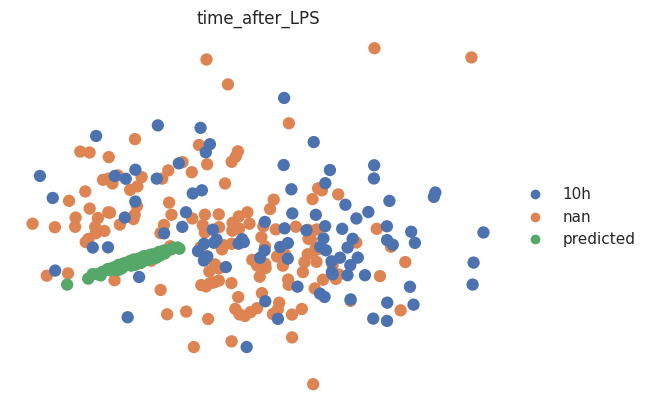

PCA plot created.



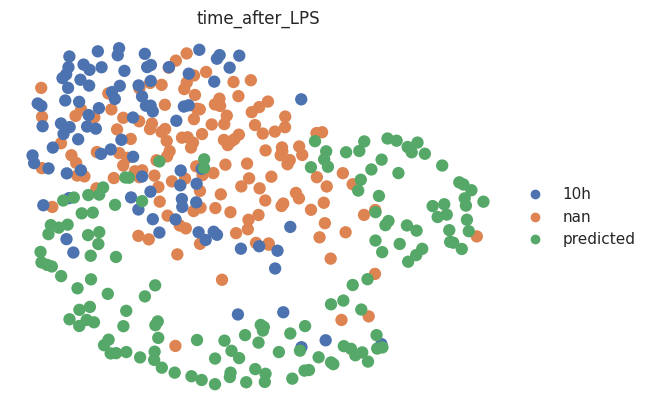

UMAP plot created.

Preprocessing data for scGen...
Selected top 100 highly variable genes.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="NK_16hi")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.74it/s, v_num=1, train_loss_step=5.72e+3, train_loss_epoch=7.56e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s, v_num=1, train_loss_step=5.72e+3, train_loss_epoch=7.56e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


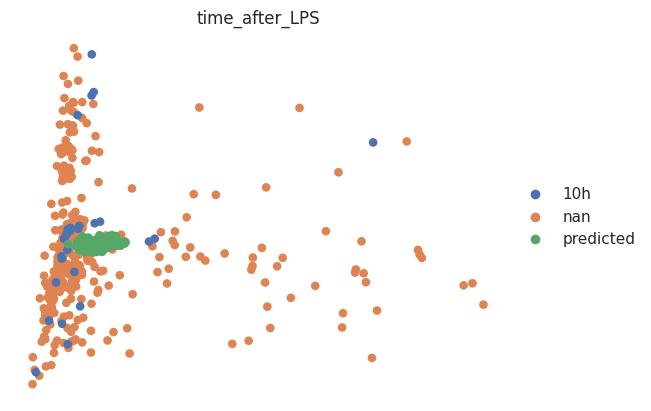

PCA plot created.



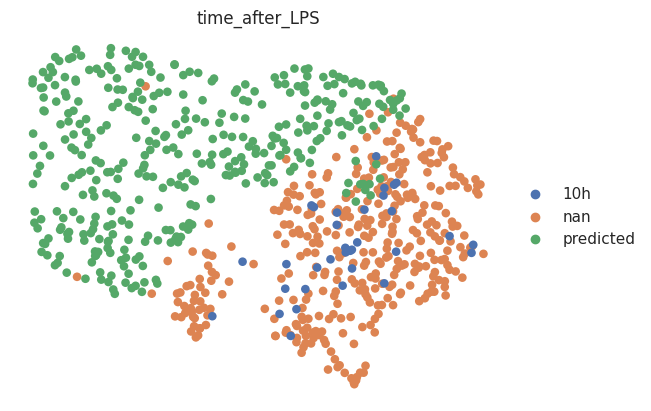

UMAP plot created.

Preprocessing data for scGen...
Selected top 100 highly variable genes.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="CD4.Naive")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.86it/s, v_num=1, train_loss_step=6.12e+3, train_loss_epoch=7.62e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s, v_num=1, train_loss_step=6.12e+3, train_loss_epoch=7.62e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


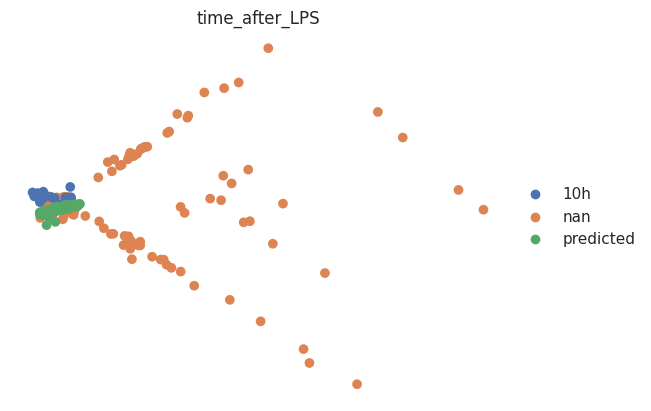

PCA plot created.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


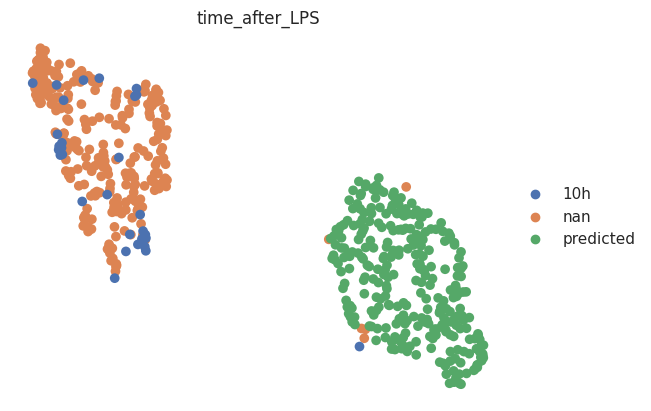

UMAP plot created.

Preprocessing data for scGen...
Selected top 100 highly variable genes.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="CD4.CM")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.73it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=7.62e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=7.62e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


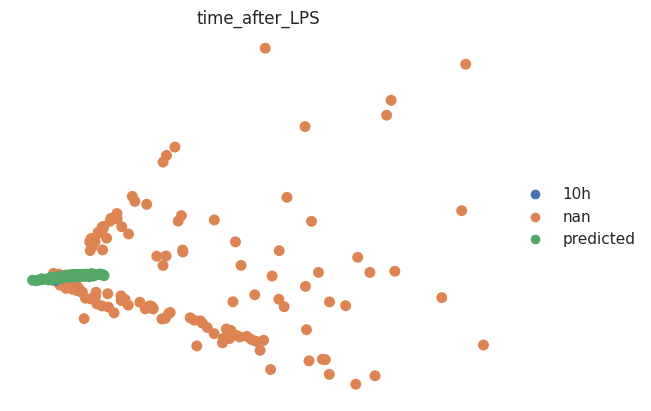

PCA plot created.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


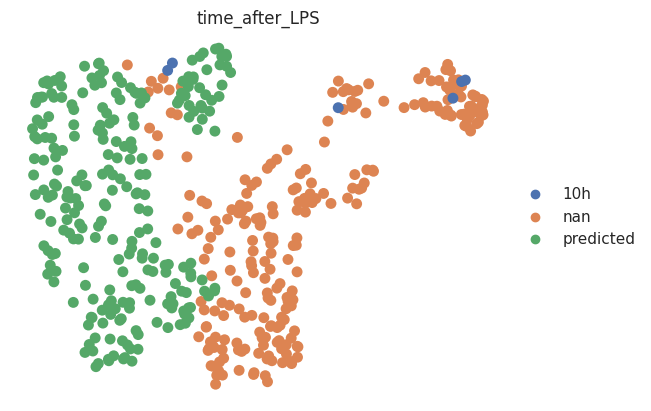

UMAP plot created.

Preprocessing data for scGen...
Selected top 100 highly variable genes.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="CD8.Naive")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.88it/s, v_num=1, train_loss_step=5.69e+3, train_loss_epoch=7.69e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s, v_num=1, train_loss_step=5.69e+3, train_loss_epoch=7.69e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


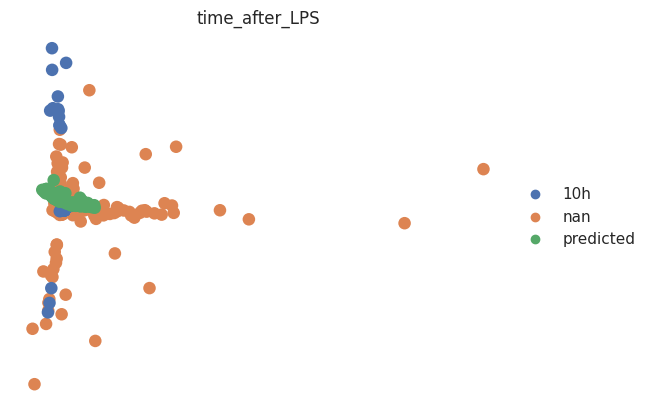

PCA plot created.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


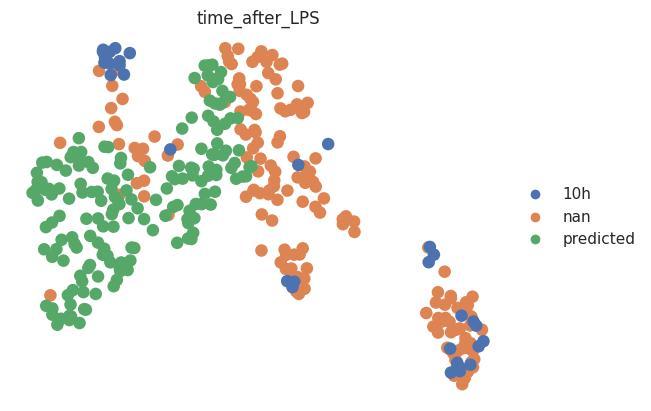

UMAP plot created.

Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="B_naive")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:16<00:00,  3.89it/s, v_num=1, train_loss_step=7.14e+3, train_loss_epoch=7.53e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s, v_num=1, train_loss_step=7.14e+3, train_loss_epoch=7.53e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


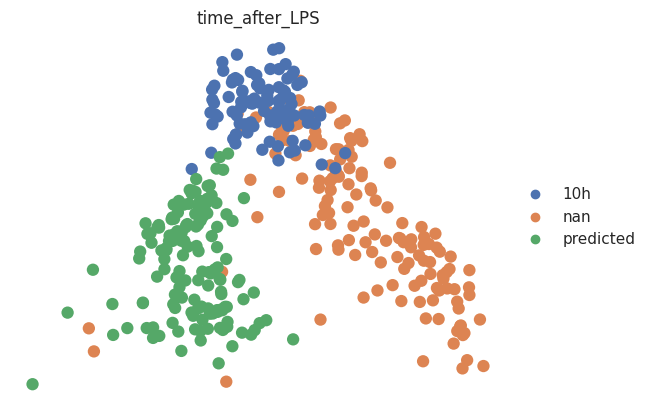

PCA plot created.



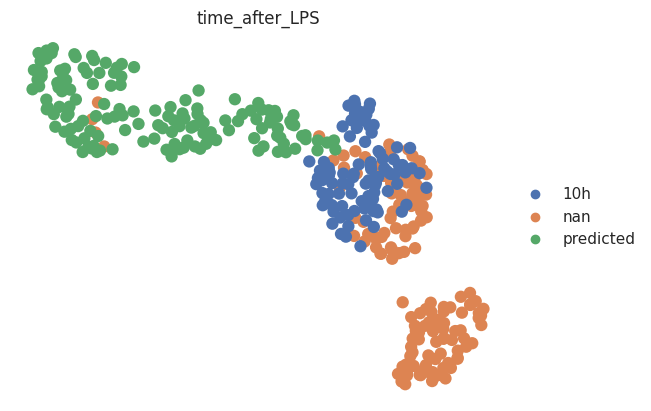

UMAP plot created.

Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="NK_16hi")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.85it/s, v_num=1, train_loss_step=6.6e+3, train_loss_epoch=7.55e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s, v_num=1, train_loss_step=6.6e+3, train_loss_epoch=7.55e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


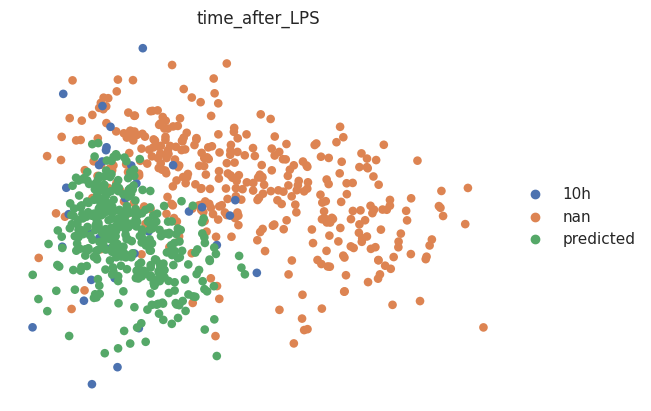

PCA plot created.



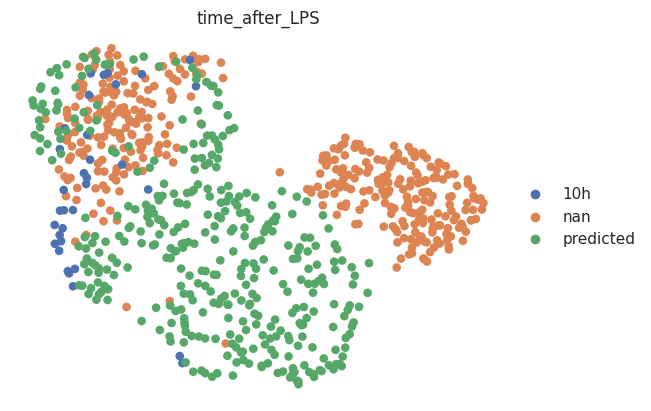

UMAP plot created.

Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="CD4.Naive")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.89it/s, v_num=1, train_loss_step=6.16e+3, train_loss_epoch=7.6e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s, v_num=1, train_loss_step=6.16e+3, train_loss_epoch=7.6e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


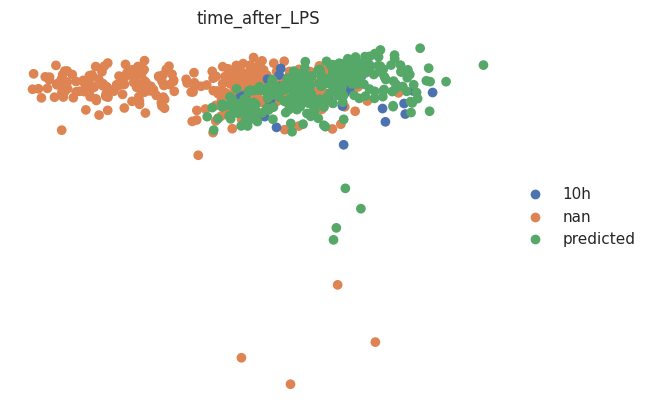

PCA plot created.



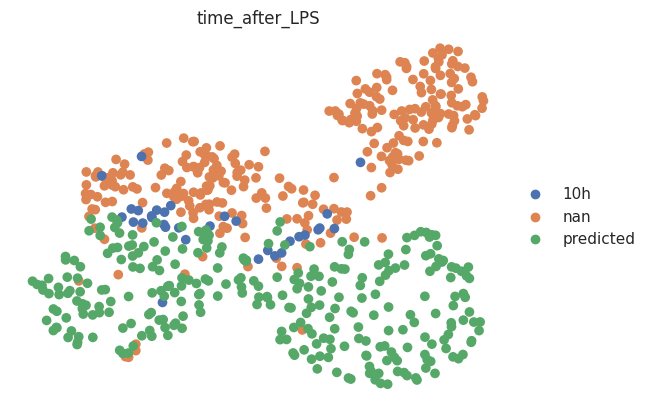

UMAP plot created.

Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="CD4.CM")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.67it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=7.56e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=7.56e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


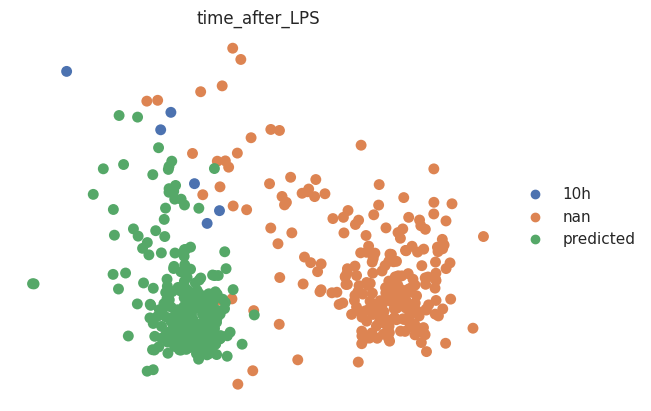

PCA plot created.



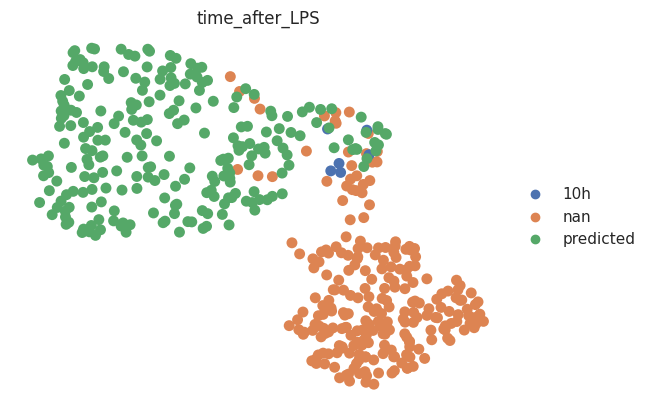

UMAP plot created.

Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: (author_cell_type=="CD8.Naive")&(time_after_LPS=="10h")

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='time_after_LPS' and labels_key='author_cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers

Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  3.69it/s, v_num=1, train_loss_step=6.11e+3, train_loss_epoch=7.59e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s, v_num=1, train_loss_step=6.11e+3, train_loss_epoch=7.59e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...
Evaluation data prepared.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


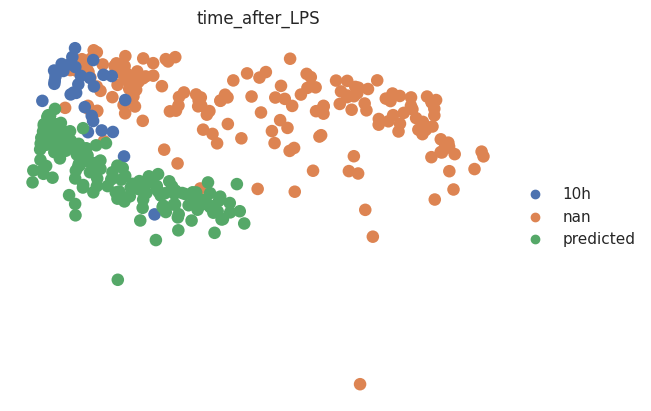

PCA plot created.



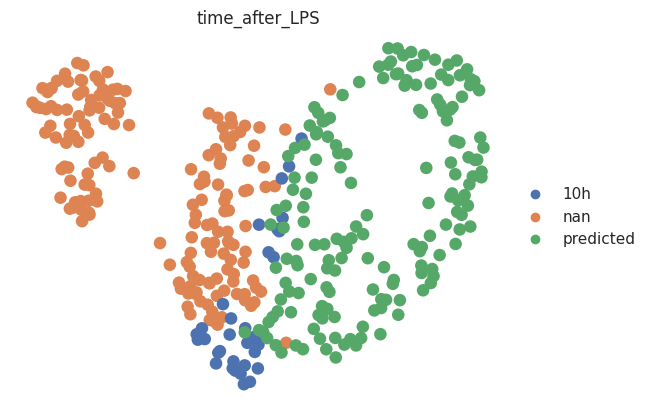

UMAP plot created.

  celltype_to_predict          Type   r2_mean    r2_std  dist_scaled  \
0             B_naive  top 100 DEGs  0.892259  0.004254     1.083576   
1             NK_16hi  top 100 DEGs  0.896647  0.012307     0.823678   
2           CD4.Naive  top 100 DEGs  0.915032  0.009883     0.813716   
3              CD4.CM  top 100 DEGs  0.708175  0.071406     0.832818   
4           CD8.Naive  top 100 DEGs  0.905370  0.007719     0.747586   
5             B_naive     all genes  0.887817  0.005199     1.109080   
6             NK_16hi     all genes  0.894643  0.012451     0.837944   
7           CD4.Naive     all genes  0.916337  0.010355     0.804890   
8              CD4.CM     all genes  0.698536  0.069000     0.855730   
9           CD8.Naive     all genes  0.894212  0.007382     0.805292   

   lfc_corr  jaccard_topK   R2_mean    R2_std  MSE_mean  ...  Pearson_mean  \
0       NaN      0.000000  0.892259  0.004254  0.007395  ...      0.961857   
1       NaN      0.005025  0.89

/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [ ]:
# --------------------------------------------
# 1) helper to bootstrap *any* cell‐based metric
# --------------------------------------------
def bootstrap_metrics(
    X, real_mask, pred_mask, pca,
    n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0
):
    rng = np.random.default_rng(random_seed)
    real_idx = np.where(real_mask)[0]
    pred_idx = np.where(pred_mask)[0]
    s_r = max(1, int(frac * len(real_idx)))
    s_p = max(1, int(frac * len(pred_idx)))

    metrics = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in metrics}

    for _ in range(n_boot):
        r = rng.choice(real_idx, size=s_r, replace=True)
        p = rng.choice(pred_idx, size=s_p, replace=True)
        Y, Xp = X[r].mean(axis=0), X[p].mean(axis=0)
        d = Xp - Y

        # error
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))

        # correlation
        pear, _ = stats.pearsonr(Xp, Y)
        vals["Pearson"].append(pear)
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))

        # R² on gene‐means
        ss_res = np.sum((Y - Xp)**2)
        ss_tot = np.sum((Y - Y.mean())**2)
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)

        # distribution in PC space
        Pr, Pp = pca[r], pca[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2 * d_rp.mean() - d_rr.mean() - d_pp.mean())
        Krr = np.exp(-cdist(Pr, Pr, 'sqeuclidean')/(2*rbf_sigma**2))
        Kpp = np.exp(-cdist(Pp, Pp, 'sqeuclidean')/(2*rbf_sigma**2))
        Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/(2*rbf_sigma**2))
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

    def ms(a):
        return float(np.nanmean(a)), float(np.nanstd(a))

    out = {}
    for k in metrics:
        m, s = ms(vals[k])
        out[f"{k}_mean"] = m
        out[f"{k}_std"]  = s
    return out

# --------------------------------------------
# 1b) compute scaled Euclidean distance
# --------------------------------------------
def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
    m_ctrl = X[ctrl_mask].mean(axis=0)
    m_pert = X[pert_mask].mean(axis=0)
    m_pred = X[pred_mask].mean(axis=0)
    ok = (~np.isnan(m_ctrl)) & (~np.isnan(m_pert)) & (~np.isnan(m_pred))
    d_in  = np.linalg.norm(m_ctrl[ok] - m_pert[ok])
    d_pr  = np.linalg.norm(m_pred[ok] - m_pert[ok])
    return d_pr / (d_in + eps)

# --------------------------------------------
# 2) main loop
# --------------------------------------------
results = []
K = 100

for gene_label, hvgs in [("top 100 DEGs", 100), ("all genes", None)]:
    for celltype in common_celltypes:
        analysis = scGenPerturbationAnalysis(norm_data)

        # a) train
        analysis.preprocess_data(
            highly_variable_genes=(hvgs is not None),
            n_top_genes=hvgs or norm_data.n_vars,
        )
        analysis.prepare_training_set(
            exclude_query=f'({celltype_col}=="{celltype}")&({condition_col}=="{stim_key}")'
        )
        analysis.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
        analysis.train_model(max_epochs=n_epochs, batch_size=batch_size,
                             accelerator="gpu", devices=1)

        # b) predict & evaluate
        analysis.make_prediction(
            ctrl_key=ctrl_key, stim_key=stim_key,
            celltype_to_predict=celltype,
            condition_col=condition_col, cell_type_col=celltype_col
        )
        analysis.evaluate_prediction(
            condition_col=condition_col,
            cell_type_col=celltype_col,
            control_condition=ctrl_key,
            stimulated_condition=stim_key,
            celltype_to_evaluate=celltype,
            pca_components=pca_components
        )

        # c) extract eval_adata
        ad = analysis.eval_adata[
            analysis.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
        ].copy()
        ad.obs.rename({condition_col: "condition"}, axis=1, inplace=True)

        X     = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
        X_pca = ad.obsm["X_pca"]
        ctrl_m = ad.obs["condition"] == ctrl_key
        pert_m = ad.obs["condition"] == stim_key
        pred_m = ad.obs["condition"] == "predicted"

        # d) bootstrap metrics
        boot      = bootstrap_metrics(X, pert_m, pred_m, pca=X_pca)
        r2_mean   = boot["R2_mean"]
        r2_std    = boot["R2_std"]
        dist_scaled = compute_dist_scaled(X, ctrl_m, pert_m, pred_m)

        # e) DE‐based metrics
        sc.tl.rank_genes_groups(ad,
            groupby="condition", reference=ctrl_key,
            groups=[stim_key], method="wilcoxon", n_genes=ad.n_vars
        )
        tr = ad.uns["rank_genes_groups"]
        true_names = tr["names"][stim_key]
        true_lfcs  = tr["logfoldchanges"][stim_key]

        sc.tl.rank_genes_groups(ad,
            groupby="condition", reference=ctrl_key,
            groups=["predicted"], method="wilcoxon", n_genes=ad.n_vars
        )
        pr = ad.uns["rank_genes_groups"]
        pred_names = pr["names"]["predicted"]
        pred_lfcs  = pr["logfoldchanges"]["predicted"]

        true_top  = true_names[:K]
        pred_top  = pred_names[:K]
        shared    = set(true_top) & set(pred_top)

        if shared:
            lfc_t = []
            lfc_p = []
            for g in shared:
                i = np.where(true_names == g)[0][0]
                j = np.where(pred_names == g)[0][0]
                lfc_t.append(true_lfcs[i])
                lfc_p.append(pred_lfcs[j])
            lfc_corr = float(np.corrcoef(lfc_t, lfc_p)[0,1]) if len(shared)>1 else np.nan
        else:
            lfc_corr = np.nan

        jaccard_topK = len(shared) / (2*K - len(shared))

        # f) record
        row = {
            "celltype_to_predict": celltype,
            "Type":               gene_label,
            "r2_mean":            r2_mean,
            "r2_std":             r2_std,
            "dist_scaled":        dist_scaled,
            "lfc_corr":           lfc_corr,
            "jaccard_topK":       jaccard_topK,
            **boot
        }
        results.append(row)

results_df = pd.DataFrame(results)
print(results_df)


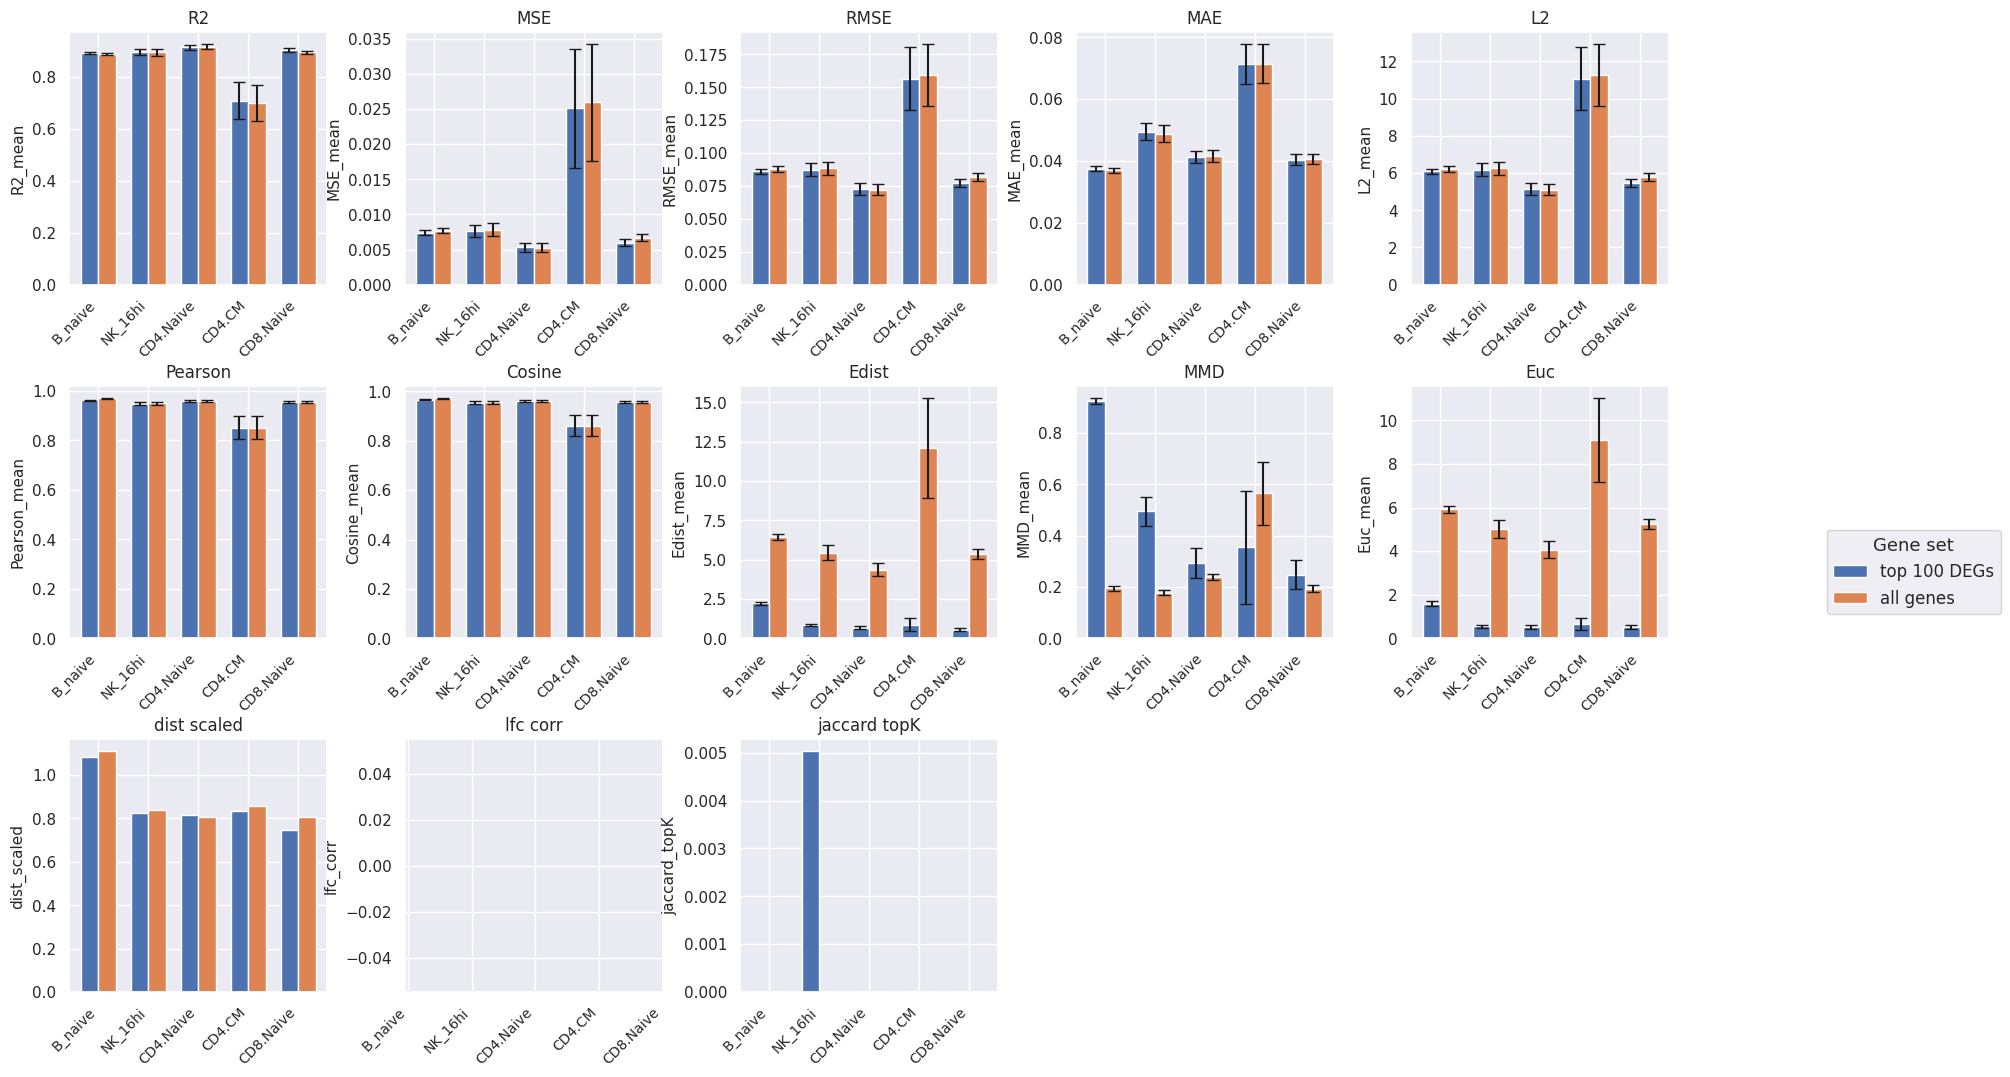

In [ ]:
# --- specify which metrics to plot (mean,std) pairs; if std_col is None we skip the error‐bar
metrics = [
    ("R2_mean",       "R2_std"),
    ("MSE_mean",      "MSE_std"),
    ("RMSE_mean",     "RMSE_std"),
    ("MAE_mean",      "MAE_std"),
    ("L2_mean",       "L2_std"),
    ("Pearson_mean",  "Pearson_std"),
    ("Cosine_mean",   "Cosine_std"),
    ("Edist_mean",    "Edist_std"),
    ("MMD_mean",      "MMD_std"),
    ("Euc_mean",      "Euc_std"),
    ("dist_scaled",   None),
    ("lfc_corr",      None),
    ("jaccard_topK",  None),
]

cell_types = list(results_df["celltype_to_predict"].unique())
gene_sets  = list(results_df["Type"].unique())

# layout: automatically choose nrows x ncols to fit all metrics
n = len(metrics)
ncols = 5
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharey=False)
axes = axes.flatten()

for ax, (mean_col, std_col) in zip(axes, metrics):
    # pivot your means
    means = (
        results_df
        .pivot(index="celltype_to_predict", columns="Type", values=mean_col)
        .loc[cell_types]
    )

    x = np.arange(len(cell_types))
    width = 0.35

    for i, gs in enumerate(gene_sets):
        y = means[gs].values
        if std_col:
            stds = (
                results_df
                .pivot(index="celltype_to_predict", columns="Type", values=std_col)
                .loc[cell_types][gs].values
            )
            ax.bar(
                x + (i-0.5)*width,
                y,
                width,
                yerr=stds,
                capsize=4,
                label=gs
            )
        else:
            ax.bar(
                x + (i-0.5)*width,
                y,
                width,
                label=gs
            )

    ax.set_xticks(x)
    ax.set_xticklabels(cell_types, rotation=45, ha="right", fontsize=10)
    ax.set_title(mean_col.replace("_", " ").replace("mean","").strip(), fontsize=12)
    ax.set_ylabel(mean_col, fontsize=11)

# remove any empty subplots
for ax in axes[n:]:
    fig.delaxes(ax)

# ——— Deduplicate legend ———
handles, labels = axes[0].get_legend_handles_labels()
unique = OrderedDict(zip(labels, handles))
fig.legend(
    unique.values(), unique.keys(),
    loc="center right",
    bbox_to_anchor=(1.02, 0.5),
    title="Gene set",
    fontsize=12,
    title_fontsize=13
)

plt.subplots_adjust(
    left=0.05, right=0.85,
    top=0.95, bottom=0.15,
    hspace=0.4, wspace=0.3
)
plt.show()


In [35]:


# --------------------------------------------
# 0) helper: mean–variance KDE L1 distance
# --------------------------------------------
def mean_var_kde_distance(
    X1,                    # (n1 × g) array for group 1 (e.g. perturbed)
    X2,                    # (n2 × g) array for group 2 (e.g. predicted)
    bandwidth: float=1.0,  # KDE bandwidth
    grid_size: int=50      # grid resolution
) -> float:
    # per-gene moments
    m1, v1 = X1.mean(axis=0), X1.var(axis=0)
    m2, v2 = X2.mean(axis=0), X2.var(axis=0)
    pts1 = np.vstack([m1, v1]).T
    pts2 = np.vstack([m2, v2]).T

    # shared grid
    mins = np.minimum(pts1.min(axis=0), pts2.min(axis=0))
    maxs = np.maximum(pts1.max(axis=0), pts2.max(axis=0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.vstack([XX.ravel(), YY.ravel()]).T

    # fit KDEs
    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)

    # evaluate & exponentiate
    logd1 = kde1.score_samples(grid)
    logd2 = kde2.score_samples(grid)
    d1, d2 = np.exp(logd1), np.exp(logd2)

    # L1 integral approx.
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)


# --------------------------------------------
# 1) bootstrap any cell‐based metric
# --------------------------------------------
def bootstrap_metrics(
    X, real_mask, pred_mask, pca,
    n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0
):
    rng = np.random.default_rng(random_seed)
    real_idx = np.where(real_mask)[0]
    pred_idx = np.where(pred_mask)[0]
    s_r = max(1, int(frac * len(real_idx)))
    s_p = max(1, int(frac * len(pred_idx)))

    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}

    for _ in range(n_boot):
        r = rng.choice(real_idx, size=s_r, replace=True)
        p = rng.choice(pred_idx, size=s_p, replace=True)
        Y, Xp = X[r].mean(axis=0), X[p].mean(axis=0)
        d = Xp - Y

        # errors
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))

        # correlations
        pear, _ = stats.pearsonr(Xp, Y)
        vals["Pearson"].append(pear)
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))

        # R²
        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)

        # distribution in PC space
        Pr, Pp = pca[r], pca[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))

        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())

        Krr = np.exp(-cdist(Pr, Pr,'sqeuclidean')/(2*rbf_sigma**2))
        Kpp = np.exp(-cdist(Pp, Pp,'sqeuclidean')/(2*rbf_sigma**2))
        Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/(2*rbf_sigma**2))
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

    def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
    out = {}
    for k in keys:
        m, s = ms(vals[k])
        out[f"{k}_mean"] = m
        out[f"{k}_std"] = s
    return out


# --------------------------------------------
# 1b) scaled‐Euclidean distance helper
# --------------------------------------------
def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
    m_ctrl = X[ctrl_mask].mean(axis=0)
    m_pert = X[pert_mask].mean(axis=0)
    m_pred = X[pred_mask].mean(axis=0)
    ok = ~np.isnan(m_ctrl)&~np.isnan(m_pert)&~np.isnan(m_pred)
    d_in  = np.linalg.norm(m_ctrl[ok]-m_pert[ok])
    d_pr  = np.linalg.norm(m_pred[ok]-m_pert[ok])
    return d_pr/(d_in+eps)


# --------------------------------------------
# 2) main loop
# --------------------------------------------
results = []
K = 100  # top-K for DE

for gene_label, hvgs in [("top 100 DEGs", 100), ("all genes", None)]:
    for celltype in common_celltypes:
        analysis = scGenPerturbationAnalysis(norm_data)

        # a) train
        analysis.preprocess_data(
            highly_variable_genes = (hvgs is not None),
            n_top_genes           = hvgs or norm_data.n_vars,
        )
        analysis.prepare_training_set(
            exclude_query=f'({celltype_col}=="{celltype}")&({condition_col}=="{stim_key}")'
        )
        analysis.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
        analysis.train_model(max_epochs=n_epochs, batch_size=batch_size,
                             accelerator="gpu", devices=1)

        # b) predict & evaluate
        analysis.make_prediction(
            ctrl_key=ctrl_key, stim_key=stim_key,
            celltype_to_predict=celltype,
            condition_col=condition_col, cell_type_col=celltype_col
        )
        analysis.evaluate_prediction(
            condition_col       = condition_col,
            cell_type_col       = celltype_col,
            control_condition   = ctrl_key,
            stimulated_condition= stim_key,
            celltype_to_evaluate= celltype,
            pca_components      = pca_components
        )

        # c) extract eval_adata
        ad = analysis.eval_adata[
            analysis.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
        ].copy()
        ad.obs.rename({condition_col: "condition"}, axis=1, inplace=True)

        X      = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
        X_pca  = ad.obsm["X_pca"]
        ctrl_m = ad.obs["condition"] == ctrl_key
        pert_m = ad.obs["condition"] == stim_key
        pred_m = ad.obs["condition"] == "predicted"

        # d) bootstrap metrics
        boot = bootstrap_metrics(X, pert_m, pred_m, pca=X_pca)
        r2_mean, r2_std = boot["R2_mean"], boot["R2_std"]

        # e) scaled distance
        dist_scaled = compute_dist_scaled(X, ctrl_m, pert_m, pred_m)

        # f) mean–var KDE distance
        mean_var_distn = mean_var_kde_distance(
            X[pert_m,:], X[pred_m,:], bandwidth=1.0, grid_size=50
        )

        # g) DE‐based metrics
        sc.tl.rank_genes_groups(ad, groupby="condition", reference=ctrl_key,
                                groups=[stim_key], method="wilcoxon", n_genes=ad.n_vars)
        tr = ad.uns["rank_genes_groups"]
        true_names = tr["names"][stim_key]
        true_lfcs  = tr["logfoldchanges"][stim_key]

        sc.tl.rank_genes_groups(ad, groupby="condition", reference=ctrl_key,
                                groups=["predicted"], method="wilcoxon", n_genes=ad.n_vars)
        pr = ad.uns["rank_genes_groups"]
        pred_names = pr["names"]["predicted"]
        pred_lfcs  = pr["logfoldchanges"]["predicted"]

        true_top, pred_top = true_names[:K], pred_names[:K]
        shared = set(true_top)&set(pred_top)
        if shared:
            lfc_t = [ true_lfcs[np.where(true_names==g)[0][0]] for g in shared ]
            lfc_p = [ pred_lfcs[np.where(pred_names==g)[0][0]] for g in shared ]
            lfc_corr = float(np.corrcoef(lfc_t,lfc_p)[0,1]) if len(shared)>1 else np.nan
        else:
            lfc_corr = np.nan

        jaccard_topK = len(shared)/(2*K - len(shared))

        # h) record
        row = {
            "celltype_to_predict": celltype,
            "Type":               gene_label,
            "r2_mean":            r2_mean,
            "r2_std":             r2_std,
            "dist_scaled":        dist_scaled,
            "mean_var_distn":     mean_var_distn,
            "lfc_corr":           lfc_corr,
            "jaccard_topK":       jaccard_topK,
            **boot
        }
        results.append(row)

results_df = pd.DataFrame(results)
print(results_df)


Preprocessing data for scGen...


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scipy/sparse/_data.py:144: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


ValueError: cannot specify integer `bins` when input data contains infinity

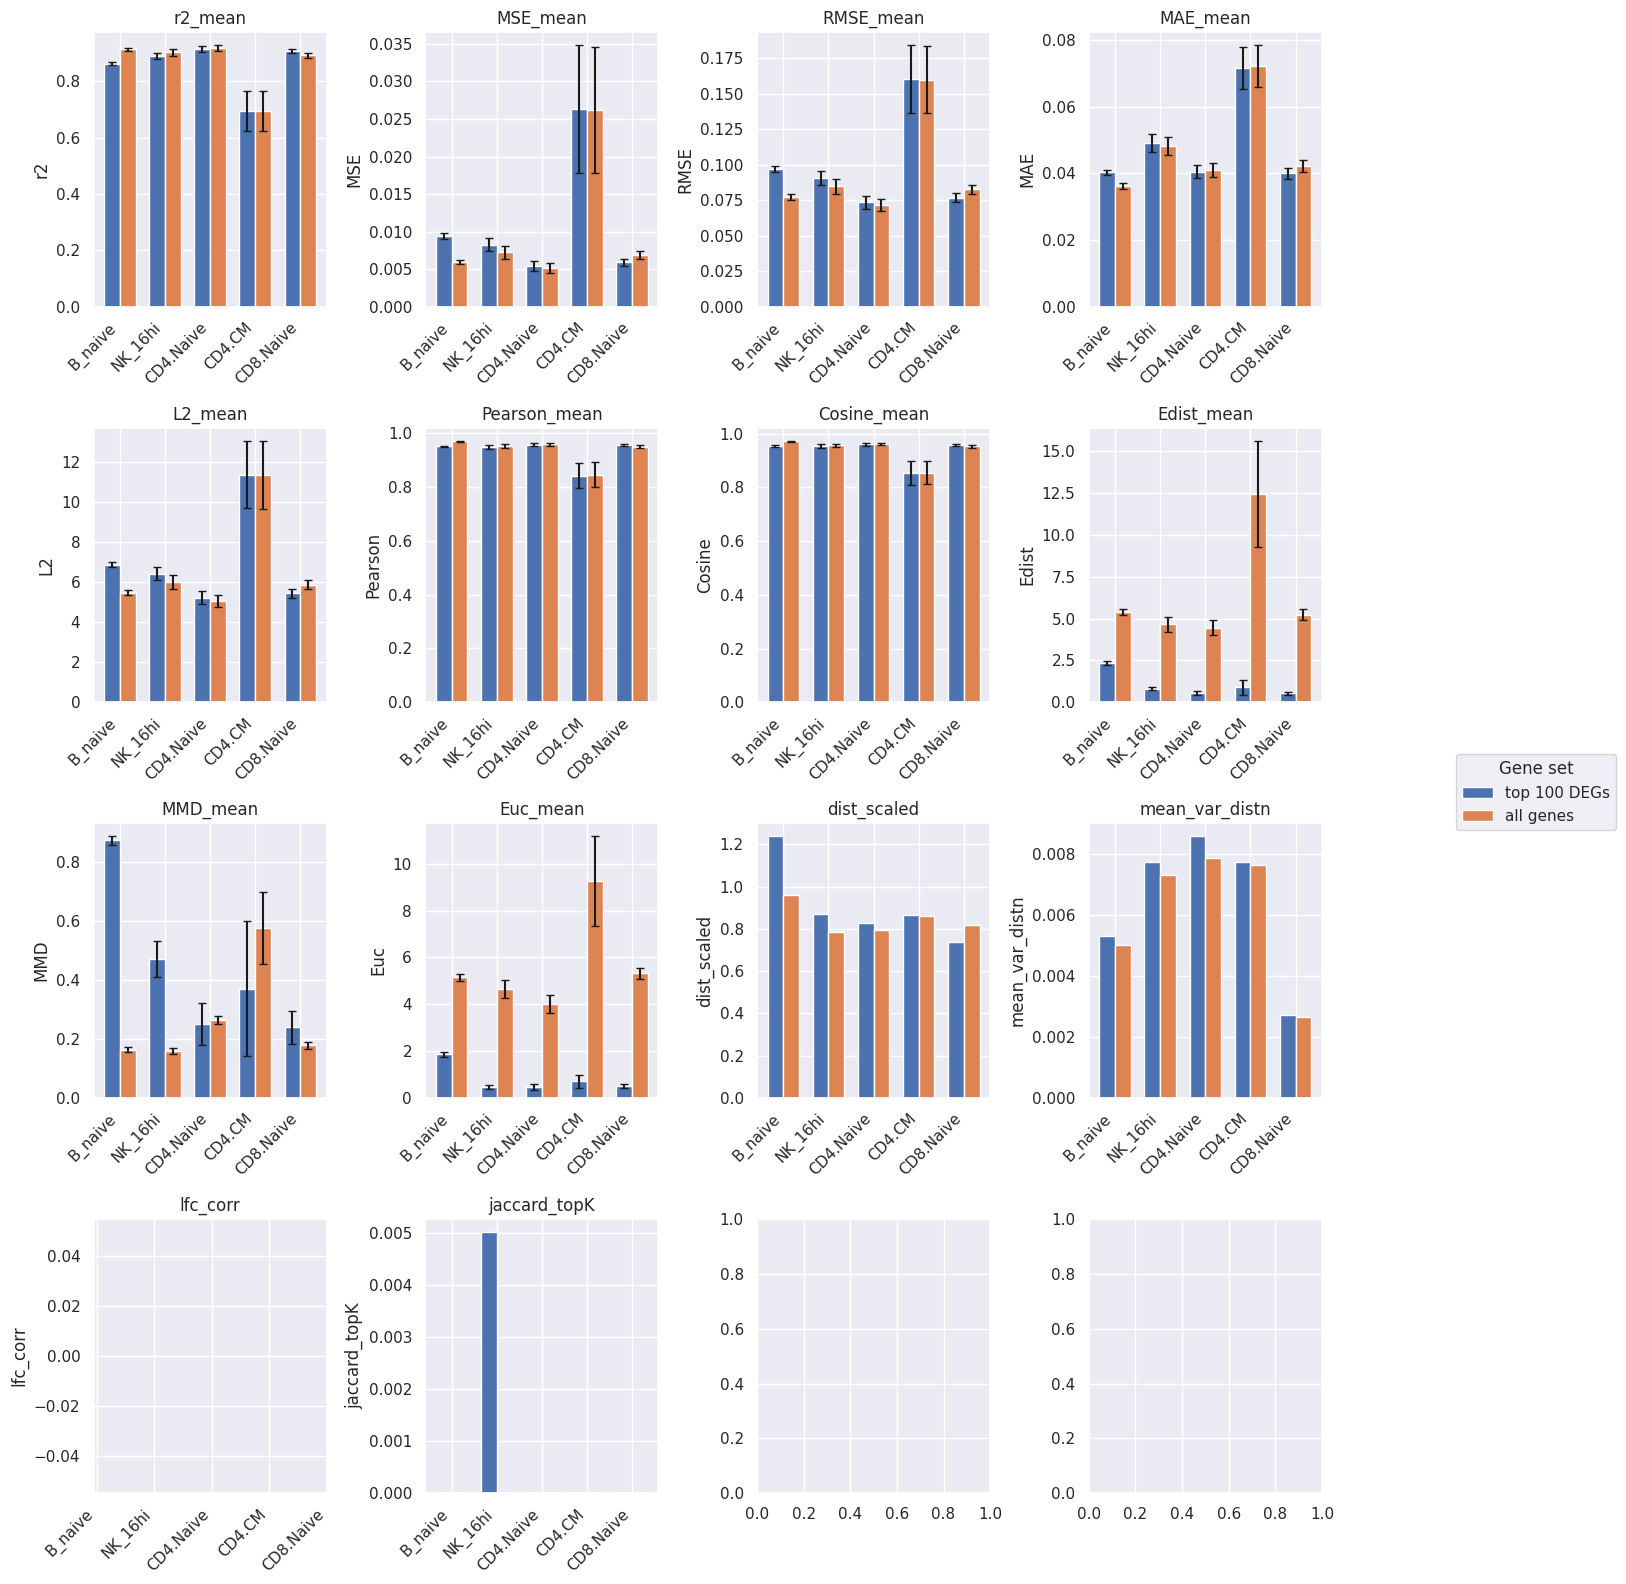

In [ ]:
# list all the paired mean/std columns you care about
metrics = [
    ("r2_mean",        "r2_std"),
    ("MSE_mean",       "MSE_std"),
    ("RMSE_mean",      "RMSE_std"),
    ("MAE_mean",       "MAE_std"),
    ("L2_mean",        "L2_std"),
    ("Pearson_mean",   "Pearson_std"),
    ("Cosine_mean",    "Cosine_std"),
    ("Edist_mean",     "Edist_std"),
    ("MMD_mean",       "MMD_std"),
    ("Euc_mean",       "Euc_std"),
    ("dist_scaled",    None),         # single‐value metric
    ("mean_var_distn", None),         # single‐value metric
    ("lfc_corr",      None),
    ("jaccard_topK",  None),
]

cell_types = results_df["celltype_to_predict"].unique()
gene_sets  = results_df["Type"].unique()

n = len(metrics)
cols = 4
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), squeeze=False)
axes = axes.ravel()

x = np.arange(len(cell_types))
width = 0.35

for ax, (mean_col, std_col) in zip(axes, metrics):
    for i, gs in enumerate(gene_sets):
        sub = results_df[results_df["Type"]==gs].set_index("celltype_to_predict")
        y = sub[mean_col].reindex(cell_types)
        if std_col:
            yerr = sub[std_col].reindex(cell_types)
        else:
            yerr = None

        ax.bar(
            x + (i-0.5)*width,
            y.values,
            width,
            yerr=yerr.values if yerr is not None else None,
            capsize=3,
            label=gs
        )

    ax.set_xticks(x)
    ax.set_xticklabels(cell_types, rotation=45, ha="right")
    ax.set_title(mean_col)
    if std_col:
        ax.set_ylabel(mean_col.replace("_mean",""))
    else:
        ax.set_ylabel(mean_col)

# dedupe legend
handles, labels = axes[0].get_legend_handles_labels()
unique = OrderedDict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(),
           loc="center right", bbox_to_anchor=(1.02,0.5),
           title="Gene set")

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()


In [19]:
norm_data = pt.dt.kang_2018()

In [20]:
counts = norm_data.obs[celltype_col].value_counts()
top1   = counts.head(1).index.tolist()

# 2) subset the AnnData in one go
norm_data = norm_data[norm_data.obs[celltype_col].isin(top1)].copy()

# 3) verify
print("Kept cell counts:")
print(norm_data.obs[celltype_col].value_counts())

Kept cell counts:
cell_type
CD4 T cells    11238
Name: count, dtype: int64


In [21]:
sc.pp.normalize_total(norm_data)

In [22]:
sc.pp.highly_variable_genes(
    norm_data,
    n_top_genes=5000,
    flavor="seurat_v3",   # or “cell_ranger”/“seurat” depending on your preference
    subset=True           # subset in place
)

/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [23]:
norm_data

AnnData object with n_obs × n_vars = 11238 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'

In [17]:
n_epochs       = 25
batch_size     = 32
pca_components = 30          
ctrl_key       = "ctrl"       
stim_key       = "stim"
condition_col  = "label"
celltype_col   = "cell_type"

In [ ]:
# # --------------------------------------------
# # 0) helper: mean–variance KDE L1 distance
# # --------------------------------------------
# def mean_var_kde_distance(X1, X2, bandwidth: float=1.0, grid_size: int=50) -> float:
#     m1, v1 = X1.mean(axis=0), X1.var(axis=0)
#     m2, v2 = X2.mean(axis=0), X2.var(axis=0)
#     pts1 = np.vstack([m1, v1]).T
#     pts2 = np.vstack([m2, v2]).T

#     mins = np.minimum(pts1.min(axis=0), pts2.min(axis=0))
#     maxs = np.maximum(pts1.max(axis=0), pts2.max(axis=0))
#     xs = np.linspace(mins[0], maxs[0], grid_size)
#     ys = np.linspace(mins[1], maxs[1], grid_size)
#     XX, YY = np.meshgrid(xs, ys)
#     grid = np.vstack([XX.ravel(), YY.ravel()]).T

#     kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
#     kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
#     logd1 = kde1.score_samples(grid)
#     logd2 = kde2.score_samples(grid)
#     d1, d2 = np.exp(logd1), np.exp(logd2)

#     dx, dy = xs[1] - xs[0], ys[1] - ys[0]
#     return float(np.abs(d1 - d2).sum() * dx * dy)


# # --------------------------------------------
# # 1) bootstrap any cell‐based metric
# # --------------------------------------------
# def bootstrap_metrics(X, real_mask, pred_mask, pca,
#                       n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0):
#     rng = np.random.default_rng(random_seed)
#     real_idx = np.where(real_mask)[0]
#     pred_idx = np.where(pred_mask)[0]
#     s_r = max(1, int(frac * len(real_idx)))
#     s_p = max(1, int(frac * len(pred_idx)))

#     keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
#     vals = {k: [] for k in keys}

#     for _ in range(n_boot):
#         r = rng.choice(real_idx, size=s_r, replace=True)
#         p = rng.choice(pred_idx, size=s_p, replace=True)
#         Y, Xp = X[r].mean(axis=0), X[p].mean(axis=0)
#         d = Xp - Y

#         # errors
#         vals["MSE"].append(np.mean(d**2))
#         vals["RMSE"].append(np.sqrt(np.mean(d**2)))
#         vals["MAE"].append(np.mean(np.abs(d)))
#         vals["L2"].append(np.linalg.norm(d))

#         # correlations
#         pear, _ = stats.pearsonr(Xp, Y)
#         vals["Pearson"].append(pear)
#         vals["Cosine"].append(1 - cosine_dist(Xp, Y))

#         # R² on means
#         ss_res = ((Y - Xp)**2).sum()
#         ss_tot = ((Y - Y.mean())**2).sum()
#         vals["R2"].append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)

#         # distribution in PCA space
#         Pr, Pp = pca[r], pca[p]
#         vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))

#         d_rr = pairwise_distances(Pr, Pr)
#         d_pp = pairwise_distances(Pp, Pp)
#         d_rp = pairwise_distances(Pr, Pp)
#         vals["Edist"].append(2 * d_rp.mean() - d_rr.mean() - d_pp.mean())

#         Krr = np.exp(-cdist(Pr, Pr, 'sqeuclidean')/(2*rbf_sigma**2))
#         Kpp = np.exp(-cdist(Pp, Pp, 'sqeuclidean')/(2*rbf_sigma**2))
#         Krp = np.exp(-cdist(Pr, Pp, 'sqeuclidean')/(2*rbf_sigma**2))
#         vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

#     def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
#     out = {}
#     for k in keys:
#         m, s = ms(vals[k])
#         out[f"{k}_mean"] = m
#         out[f"{k}_std"]  = s
#     return out


# # --------------------------------------------
# # 1b) scaled‐Euclidean distance helper
# # --------------------------------------------
# def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
#     m_ctrl = X[ctrl_mask].mean(axis=0)
#     m_pert = X[pert_mask].mean(axis=0)
#     m_pred = X[pred_mask].mean(axis=0)
#     ok = (~np.isnan(m_ctrl)) & (~np.isnan(m_pert)) & (~np.isnan(m_pred))
#     d_in = np.linalg.norm(m_ctrl[ok] - m_pert[ok])
#     d_pr = np.linalg.norm(m_pred[ok] - m_pert[ok])
#     return d_pr / (d_in + eps)


# # --------------------------------------------
# # 2) main loop
# # --------------------------------------------
# results = []
# K = 100

# condition_col = "label"
# celltype_col  = "cell_type"
# ctrl_key      = "ctrl"
# stim_key      = "stim"
# common_celltypes = norm_data.obs[celltype_col].unique().tolist()

# for gene_label, hvgs in [("top 100 DEGs", 100), ("all genes", None)]:
#     for celltype in common_celltypes:
#         # instantiate & train
#         analysis = scGenPerturbationAnalysis(norm_data)
#         analysis.preprocess_data(
#             highly_variable_genes=(hvgs is not None),
#             n_top_genes=hvgs or norm_data.n_vars,
#         )
#         analysis.prepare_training_set(
#             exclude_query=f'{celltype_col}=="{celltype}" & {condition_col}=="{stim_key}"'
#         )
#         analysis.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
#         analysis.train_model(max_epochs=n_epochs, batch_size=batch_size,
#                              accelerator="gpu", devices=1)

#         # predict & eval
#         analysis.make_prediction(
#             ctrl_key=ctrl_key, stim_key=stim_key,
#             celltype_to_predict=celltype,
#             condition_col=condition_col, cell_type_col=celltype_col
#         )
#         analysis.evaluate_prediction(
#             condition_col=condition_col, cell_type_col=celltype_col,
#             control_condition=ctrl_key, stimulated_condition=stim_key,
#             celltype_to_evaluate=celltype, pca_components=pca_components
#         )

#         # extract data
#         ad = analysis.eval_adata[
#             analysis.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
#         ].copy()
#         ad.obs.rename({condition_col: "condition"}, axis=1, inplace=True)

#         X      = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
#         X_pca  = ad.obsm["X_pca"]
#         ctrl_m = ad.obs["condition"] == ctrl_key
#         pert_m = ad.obs["condition"] == stim_key
#         pred_m = ad.obs["condition"] == "predicted"

#         # bootstrap
#         boot       = bootstrap_metrics(X, pert_m, pred_m, X_pca)
#         r2_mean    = boot["R2_mean"]
#         r2_std     = boot["R2_std"]

#         # new metrics
#         dist_scaled    = compute_dist_scaled(X, ctrl_m, pert_m, pred_m)
#         mean_var_distn = mean_var_kde_distance(X[pert_m], X[pred_m])

#         # DE‐based
#         sc.tl.rank_genes_groups(ad, groupby="condition", reference=ctrl_key,
#                                 groups=[stim_key], method="wilcoxon", n_genes=ad.n_vars)
#         tr = ad.uns["rank_genes_groups"]
#         true_names = tr["names"][stim_key]
#         true_lfcs  = tr["logfoldchanges"][stim_key]

#         sc.tl.rank_genes_groups(ad, groupby="condition", reference=ctrl_key,
#                                 groups=["predicted"], method="wilcoxon", n_genes=ad.n_vars)
#         pr = ad.uns["rank_genes_groups"]
#         pred_names = pr["names"]["predicted"]
#         pred_lfcs  = pr["logfoldchanges"]["predicted"]

#         true_top = true_names[:K]
#         pred_top = pred_names[:K]
#         shared   = set(true_top) & set(pred_top)
#         if shared:
#             lfc_t = [true_lfcs[np.where(true_names == g)[0][0]] for g in shared]
#             lfc_p = [pred_lfcs[np.where(pred_names == g)[0][0]] for g in shared]
#             lfc_corr = float(np.corrcoef(lfc_t, lfc_p)[0,1]) if len(shared)>1 else np.nan
#         else:
#             lfc_corr = np.nan

#         jaccard_topK = len(shared) / (2*K - len(shared))

#         # record
#         row = {
#             "celltype_to_predict": celltype,
#             "Type":               gene_label,
#             "r2_mean":            r2_mean,
#             "r2_std":             r2_std,
#             "dist_scaled":        dist_scaled,
#             "mean_var_distn":     mean_var_distn,
#             "lfc_corr":           lfc_corr,
#             "jaccard_topK":       jaccard_topK,
#             **boot
#         }
#         results.append(row)

# results_df = pd.DataFrame(results)
# print(results_df)


Preprocessing data for scGen...


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scipy/sparse/_data.py:144: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


ValueError: cannot specify integer `bins` when input data contains infinity

In [ ]:
# —————————————————————————————————————————————
# 0) Load & preprocess your data (e.g. from the scGen tutorial)
# —————————————————————————————————————————————

# load the Kang 2018 example
adata = pt.dt.kang_2018()
adata.raw = adata.copy()

# total‐count normalize, then log1p
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# force any NaN/±Inf → 0
if sparse.issparse(adata.X):
    mat = adata.X.toarray()
    mat = np.nan_to_num(mat, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = sparse.csr_matrix(mat)
else:
    adata.X = np.nan_to_num(adata.X, nan=0.0, posinf=0.0, neginf=0.0)

# store for the loop
norm_data = adata

# —————————————————————————————————————————————
# 1) helper: mean–variance KDE L1 distance
# —————————————————————————————————————————————
def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    m1, v1 = X1.mean(axis=0), X1.var(axis=0)
    m2, v2 = X2.mean(axis=0), X2.var(axis=0)
    pts1, pts2 = np.vstack([m1, v1]).T, np.vstack([m2, v2]).T

    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.vstack([XX.ravel(), YY.ravel()]).T

    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
    logd1, logd2 = kde1.score_samples(grid), kde2.score_samples(grid)
    d1, d2 = np.exp(logd1), np.exp(logd2)

    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)

# —————————————————————————————————————————————
# 2) helper: bootstrap any cell‐based metric
# —————————————————————————————————————————————
def bootstrap_metrics(X, real_mask, pred_mask, pca, n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0):
    rng = np.random.default_rng(random_seed)
    real_idx, pred_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
    s_r, s_p = max(1,int(frac*len(real_idx))), max(1,int(frac*len(pred_idx)))

    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}

    for _ in range(n_boot):
        r = rng.choice(real_idx, size=s_r, replace=True)
        p = rng.choice(pred_idx, size=s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d = Xp - Y

        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))

        pear, _ = stats.pearsonr(Xp, Y)
        vals["Pearson"].append(pear)
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))

        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)

        Pr, Pp = pca[r], pca[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0)-Pp.mean(0)))

        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())

        Krr = np.exp(-cdist(Pr, Pr, 'sqeuclidean')/(2*rbf_sigma**2))
        Kpp = np.exp(-cdist(Pp, Pp, 'sqeuclidean')/(2*rbf_sigma**2))
        Krp = np.exp(-cdist(Pr, Pp, 'sqeuclidean')/(2*rbf_sigma**2))
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

    def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
    out = {}
    for k in keys:
        m,s = ms(vals[k])
        out[f"{k}_mean"] = m
        out[f"{k}_std"]  = s
    return out

# —————————————————————————————————————————————
# 3) helper: scaled‐Euclidean distance
# —————————————————————————————————————————————
def compute_dist_scaled(X, c_m, p_m, q_m, eps=1e-8):
    m0, m1, m2 = X[c_m].mean(0), X[p_m].mean(0), X[q_m].mean(0)
    ok = ~(np.isnan(m0)|np.isnan(m1)|np.isnan(m2))
    d_in = np.linalg.norm(m0[ok]-m1[ok])
    d_pr = np.linalg.norm(m2[ok]-m1[ok])
    return d_pr/(d_in+eps)

# —————————————————————————————————————————————
# 4) run the full loop
# —————————————————————————————————————————————
results = []
K = 100

condition_col, celltype_col = "label", "cell_type"
ctrl_key, stim_key = "ctrl", "stim"
common_celltypes = norm_data.obs[celltype_col].unique().tolist()

for gene_label, hvgs in [("top 100 DEGs",100),("all genes",None)]:
    for ct in common_celltypes:
        an = scGenPerturbationAnalysis(norm_data)
        an.preprocess_data(highly_variable_genes=(hvgs is not None),
                           n_top_genes=hvgs or norm_data.n_vars)
        an.prepare_training_set(exclude_query=f'{celltype_col}=="{ct}" & {condition_col}=="{stim_key}"')
        an.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
        an.train_model(max_epochs=n_epochs, batch_size=batch_size, accelerator="gpu", devices=1)

        an.make_prediction(ctrl_key=ctrl_key, stim_key=stim_key,
                           celltype_to_predict=ct,
                           condition_col=condition_col, cell_type_col=celltype_col)
        an.evaluate_prediction(condition_col=condition_col,
                               cell_type_col=celltype_col,
                               control_condition=ctrl_key,
                               stimulated_condition=stim_key,
                               celltype_to_evaluate=ct,
                               pca_components=pca_components)

        ad = an.eval_adata[an.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])].copy()
        ad.obs.rename({condition_col:"condition"},axis=1,inplace=True)

        X     = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
        X_pca = ad.obsm["X_pca"]
        c_m   = ad.obs["condition"]==ctrl_key
        p_m   = ad.obs["condition"]==stim_key
        q_m   = ad.obs["condition"]=="predicted"

        boot   = bootstrap_metrics(X, p_m, q_m, X_pca)
        r2_m, r2_s = boot["R2_mean"], boot["R2_std"]

        dist_s  = compute_dist_scaled(X, c_m, p_m, q_m)
        kde_d   = mean_var_kde_distance(X[p_m], X[q_m])

        sc.tl.rank_genes_groups(ad, groupby="condition", reference=ctrl_key,
                                groups=[stim_key], method="wilcoxon", n_genes=ad.n_vars)
        tr = ad.uns["rank_genes_groups"]
        tn, tl = tr["names"][stim_key], tr["logfoldchanges"][stim_key]

        sc.tl.rank_genes_groups(ad, groupby="condition", reference=ctrl_key,
                                groups=["predicted"], method="wilcoxon", n_genes=ad.n_vars)
        pr = ad.uns["rank_genes_groups"]
        pn, pl = pr["names"]["predicted"], pr["logfoldchanges"]["predicted"]

        T, P = tn[:K], pn[:K]
        S = set(T)&set(P)
        if S:
            lt = [ tl[np.where(tn==g)[0][0]] for g in S ]
            lp = [ pl[np.where(pn==g)[0][0]] for g in S ]
            fc_corr = np.corrcoef(lt, lp)[0,1] if len(S)>1 else np.nan
        else:
            fc_corr = np.nan

        jac = len(S)/(2*K - len(S))

        row = dict(
            celltype_to_predict=ct,
            Type=gene_label,
            r2_mean=r2_m, r2_std=r2_s,
            dist_scaled=dist_s, mean_var_distn=kde_d,
            lfc_corr=fc_corr, jaccard_topK=jac,
            **boot
        )
        results.append(row)

results_df = pd.DataFrame(results)
print(results_df)


Preprocessing data for scGen...
Selected top 100 highly variable genes.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: cell_type=="CD14+ Monocytes" & label=="stim"

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='label' and labels_key='cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 2/25:   4%|▍         | 1/25 [01:06<26:41, 66.74s/it, v_num=1, train_loss_step=903, train_loss_epoch=5.78e+3]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Preprocessing data for scGen...
Selected top 100 highly variable genes.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: cell_type == "CD4 T cells" & label == "stim"

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='label' and labels_key='cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 25/25: 100%|██████████| 25/25 [03:23<00:00,  7.62s/it, v_num=1, train_loss_step=709, train_loss_epoch=3.66e+3]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [03:23<00:00,  8.13s/it, v_num=1, train_loss_step=709, train_loss_epoch=3.66e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Evaluation data prepared.



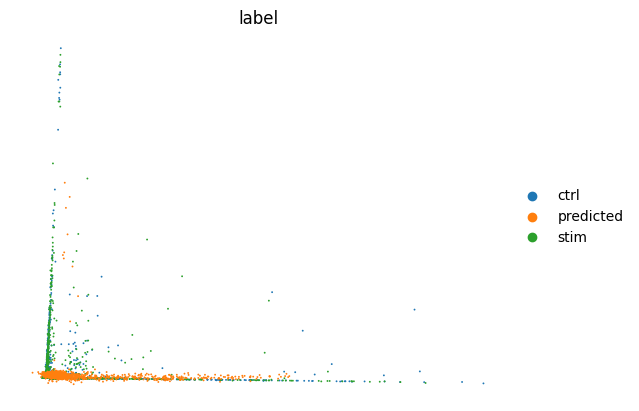

PCA plot created.



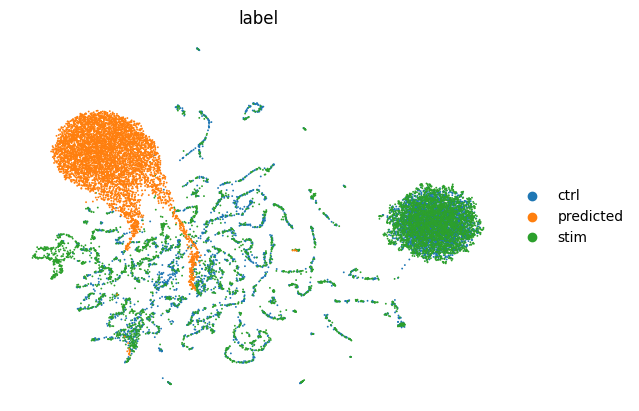

UMAP plot created.



/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: cell_type == "CD4 T cells" & label == "stim"

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='label' and labels_key='cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 25/25: 100%|██████████| 25/25 [03:25<00:00,  7.89s/it, v_num=1, train_loss_step=849, train_loss_epoch=3.65e+3]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [03:25<00:00,  8.23s/it, v_num=1, train_loss_step=849, train_loss_epoch=3.65e+3]
scGen model trained.

scGen model saved to 'model_perturbation_prediction.pt'.

Making predictions...


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Predictions made.

Evaluating predictions...


/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Evaluation data prepared.



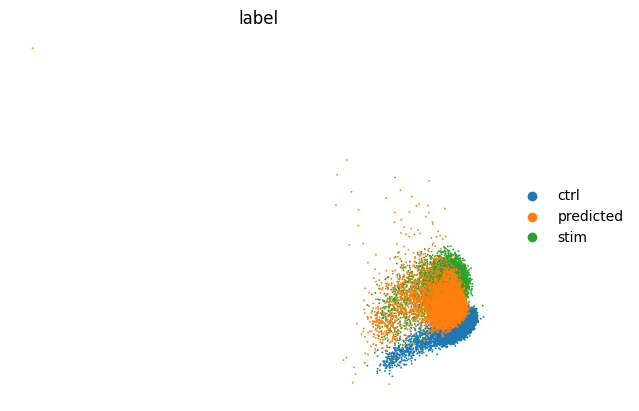

PCA plot created.



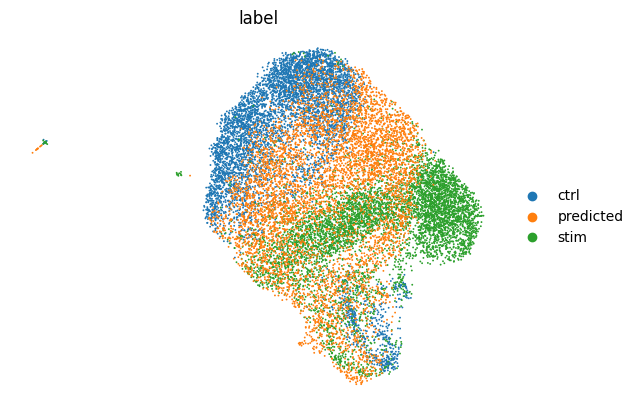

UMAP plot created.



KeyboardInterrupt: 

In [ ]:
# --------------------------------------------
# 0) helpers: mean–variance KDE & bootstrap metrics & scaled‐Euclidean
# --------------------------------------------
def mean_var_kde_distance(X1, X2, bandwidth: float = 1.0, grid_size: int = 50) -> float:
    m1, v1 = X1.mean(axis=0), X1.var(axis=0)
    m2, v2 = X2.mean(axis=0), X2.var(axis=0)
    pts1 = np.vstack([m1, v1]).T
    pts2 = np.vstack([m2, v2]).T

    mins = np.minimum(pts1.min(axis=0), pts2.min(axis=0))
    maxs = np.maximum(pts1.max(axis=0), pts2.max(axis=0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.vstack([XX.ravel(), YY.ravel()]).T

    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
    logd1 = kde1.score_samples(grid)
    logd2 = kde2.score_samples(grid)
    d1, d2 = np.exp(logd1), np.exp(logd2)

    dx, dy = xs[1] - xs[0], ys[1] - ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca,
                      n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0):
    rng       = np.random.default_rng(random_seed)
    real_idx  = np.where(real_mask)[0]
    pred_idx  = np.where(pred_mask)[0]
    s_r       = max(1, int(frac * len(real_idx)))
    s_p       = max(1, int(frac * len(pred_idx)))
    keys      = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals      = {k: [] for k in keys}

    for _ in range(n_boot):
        r = rng.choice(real_idx, size=s_r, replace=True)
        p = rng.choice(pred_idx, size=s_p, replace=True)
        Y, Xp = X[r].mean(axis=0), X[p].mean(axis=0)
        d     = Xp - Y

        # errors
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))

        # correlations
        pear, _ = stats.pearsonr(Xp, Y)
        vals["Pearson"].append(pear)
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))

        # R²
        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)

        # distribution in PCA
        Pr, Pp = pca[r], pca[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2 * d_rp.mean() - d_rr.mean() - d_pp.mean())

        Krr = np.exp(-cdist(Pr, Pr, 'sqeuclidean')/(2*rbf_sigma**2))
        Kpp = np.exp(-cdist(Pp, Pp, 'sqeuclidean')/(2*rbf_sigma**2))
        Krp = np.exp(-cdist(Pr, Pp, 'sqeuclidean')/(2*rbf_sigma**2))
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

    def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
    out = {}
    for k in keys:
        m, s = ms(vals[k])
        out[f"{k}_mean"] = m
        out[f"{k}_std"]  = s
    return out

def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
    m_ctrl = X[ctrl_mask].mean(axis=0)
    m_pert = X[pert_mask].mean(axis=0)
    m_pred = X[pred_mask].mean(axis=0)
    ok     = (~np.isnan(m_ctrl)) & (~np.isnan(m_pert)) & (~np.isnan(m_pred))
    d_in   = np.linalg.norm(m_ctrl[ok] - m_pert[ok])
    d_pr   = np.linalg.norm(m_pred[ok] - m_pert[ok])
    return d_pr / (d_in + eps)

# --------------------------------------------
# 2) decide which cell‐types to test
# --------------------------------------------
condition_col      = "label"
celltype_col       = "cell_type"
ctrl_key           = "ctrl"
stim_key           = "stim"
common_celltypes   = norm_data.obs[celltype_col].unique().tolist()

# Set to None for all, or a list e.g. ["CD4 T cells"] to test just those
celltypes_to_test = ["CD4 T cells"]

if celltypes_to_test is None:
    loop_celltypes = common_celltypes
else:
    missing = set(celltypes_to_test) - set(common_celltypes)
    if missing:
        raise ValueError(f"These cell types not in your data: {missing}")
    loop_celltypes = celltypes_to_test

# --------------------------------------------
# 3) main loop
# --------------------------------------------
results = []
K = 100

for gene_label, hvgs in [("top 100 DEGs", 100), ("all genes", None)]:
    for celltype in loop_celltypes:
        an = scGenPerturbationAnalysis(norm_data)
        an.preprocess_data(
            highly_variable_genes = (hvgs is not None),
            n_top_genes           = hvgs or norm_data.n_vars,
        )
        an.prepare_training_set(
            exclude_query=(
                f'{celltype_col} == "{celltype}" '
                f'& {condition_col} == "{stim_key}"'
            )
        )
        an.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
        an.train_model(
            max_epochs=n_epochs,
            batch_size=batch_size,
            accelerator="gpu",
            devices=1,
        )

        an.make_prediction(
            ctrl_key=ctrl_key,
            stim_key=stim_key,
            celltype_to_predict=celltype,
            condition_col=condition_col,
            cell_type_col=celltype_col,
        )
        an.evaluate_prediction(
            condition_col=condition_col,
            cell_type_col=celltype_col,
            control_condition=ctrl_key,
            stimulated_condition=stim_key,
            celltype_to_evaluate=celltype,
            pca_components=pca_components,
        )

        ad     = an.eval_adata[
            an.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
        ].copy()
        ad.obs.rename({condition_col: "condition"}, axis=1, inplace=True)

        X      = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
        X_pca  = ad.obsm["X_pca"]
        ctrl_m = ad.obs["condition"] == ctrl_key
        pert_m = ad.obs["condition"] == stim_key
        pred_m = ad.obs["condition"] == "predicted"

        boot           = bootstrap_metrics(X, pert_m, pred_m, X_pca)
        r2_mean, r2_std= boot["R2_mean"], boot["R2_std"]
        dist_scaled    = compute_dist_scaled(X, ctrl_m, pert_m, pred_m)
        mean_var_distn = mean_var_kde_distance(X[pert_m], X[pred_m])

        sc.tl.rank_genes_groups(ad,
            groupby="condition", reference=ctrl_key,
            groups=[stim_key], method="wilcoxon", n_genes=ad.n_vars
        )
        tr         = ad.uns["rank_genes_groups"]
        true_names = tr["names"][stim_key]
        true_lfcs  = tr["logfoldchanges"][stim_key]

        sc.tl.rank_genes_groups(ad,
            groupby="condition", reference=ctrl_key,
            groups=["predicted"], method="wilcoxon", n_genes=ad.n_vars
        )
        pr          = ad.uns["rank_genes_groups"]
        pred_names  = pr["names"]["predicted"]
        pred_lfcs   = pr["logfoldchanges"]["predicted"]

        true_top    = true_names[:K]
        pred_top    = pred_names[:K]
        shared      = set(true_top) & set(pred_top)
        if shared:
            lfc_t     = [true_lfcs[np.where(true_names == g)[0][0]] for g in shared]
            lfc_p     = [pred_lfcs[np.where(pred_names == g)[0][0]] for g in shared]
            lfc_corr  = float(np.corrcoef(lfc_t, lfc_p)[0,1]) if len(shared)>1 else np.nan
        else:
            lfc_corr  = np.nan

        jaccard_topK = len(shared) / (2*K - len(shared))

        row = {
            "celltype_to_predict": celltype,
            "Type":               gene_label,
            "r2_mean":            r2_mean,
            "r2_std":             r2_std,
            "dist_scaled":        dist_scaled,
            "mean_var_distn":     mean_var_distn,
            "lfc_corr":           lfc_corr,
            "jaccard_topK":       jaccard_topK,
            **boot
        }
        results.append(row)

results_df = pd.DataFrame(results)
print(results_df)


In [ ]:
#Fix

In [ ]:
# --------------------------------------------
# 0) helpers: mean–variance KDE & bootstrap metrics & scaled‐Euclidean
# --------------------------------------------
def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    m1, v1 = X1.mean(axis=0), X1.var(axis=0)
    m2, v2 = X2.mean(axis=0), X2.var(axis=0)
    pts1 = np.vstack([m1, v1]).T
    pts2 = np.vstack([m2, v2]).T

    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.vstack([XX.ravel(), YY.ravel()]).T

    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
    logd1 = kde1.score_samples(grid)
    logd2 = kde2.score_samples(grid)
    d1, d2 = np.exp(logd1), np.exp(logd2)

    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca,
                      n_boot=200, frac=0.8, random_seed=0, rbf_sigma=1.0):
    rng = np.random.default_rng(random_seed)
    real_idx, pred_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
    s_r, s_p = max(1,int(frac*len(real_idx))), max(1,int(frac*len(pred_idx)))
    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}

    for _ in range(n_boot):
        r = rng.choice(real_idx, size=s_r, replace=True)
        p = rng.choice(pred_idx, size=s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d = Xp - Y

        # errors
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))

        # correlations
        pear, _ = stats.pearsonr(Xp, Y)
        vals["Pearson"].append(pear)
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))

        # R²
        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)

        # distribution in PCA
        Pr, Pp = pca[r], pca[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))

        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())

        Krr = np.exp(-cdist(Pr, Pr,'sqeuclidean')/(2*rbf_sigma**2))
        Kpp = np.exp(-cdist(Pp, Pp,'sqeuclidean')/(2*rbf_sigma**2))
        Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/(2*rbf_sigma**2))
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())

    def ms(a): return float(np.nanmean(a)), float(np.nanstd(a))
    out = {}
    for k in keys:
        m,s = ms(vals[k])
        out[f"{k}_mean"] = m
        out[f"{k}_std"]  = s
    return out

def compute_dist_scaled(X, ctrl_mask, pert_mask, pred_mask, eps=1e-8):
    m_ctrl, m_pert, m_pred = X[ctrl_mask].mean(0), X[pert_mask].mean(0), X[pred_mask].mean(0)
    ok = ~np.isnan(m_ctrl)&~np.isnan(m_pert)&~np.isnan(m_pred)
    d_in = np.linalg.norm(m_ctrl[ok]-m_pert[ok])
    d_pr = np.linalg.norm(m_pred[ok]-m_pert[ok])
    return d_pr/(d_in+eps)

# --------------------------------------------
# 1) set up
# --------------------------------------------
condition_col = "label"
celltype_col  = "cell_type"
ctrl_key      = "ctrl"
stim_key      = "stim"
# common_celltypes = norm_data.obs[celltype_col].unique().tolist()
common_celltypes = ['CD4 T cells']
K = 100          # top‐K DE genes
pca_components = 20  # same as your evaluate_prediction

results = []

# --------------------------------------------
# 2) loop over cell types—train once
# --------------------------------------------
for celltype in common_celltypes:
    # --- train on all genes ---
    an = scGenPerturbationAnalysis(norm_data)
    an.preprocess_data(
        highly_variable_genes=False,
        n_top_genes=norm_data.n_vars
    )
    an.prepare_training_set(
        exclude_query=f'{celltype_col}=="{celltype}" & {condition_col}=="{stim_key}"'
    )
    an.setup_anndata(batch_key=condition_col, labels_key=celltype_col)
    an.train_model(
        max_epochs=n_epochs, batch_size=batch_size,
        accelerator="gpu", devices=1
    )

    # --- predict & evaluate ---
    an.make_prediction(
        ctrl_key=ctrl_key, stim_key=stim_key,
        celltype_to_predict=celltype,
        condition_col=condition_col,
        cell_type_col=celltype_col
    )
    an.evaluate_prediction(
        condition_col=condition_col,
        cell_type_col=celltype_col,
        control_condition=ctrl_key,
        stimulated_condition=stim_key,
        celltype_to_evaluate=celltype,
        pca_components=pca_components
    )

    # pull out eval data
    ad = an.eval_adata[
        an.eval_adata.obs[condition_col].isin([ctrl_key, stim_key, "predicted"])
    ].copy()
    ad.obs.rename({condition_col:"condition"}, axis=1, inplace=True)

    X_full    = ad.X.toarray() if sparse.issparse(ad.X) else ad.X
    Xpca_full = ad.obsm["X_pca"]
    ctrl_m    = ad.obs["condition"] == ctrl_key
    pert_m    = ad.obs["condition"] == stim_key
    pred_m    = ad.obs["condition"] == "predicted"

    # get DE gene names
    sc.tl.rank_genes_groups(
        ad, groupby="condition", reference=ctrl_key,
        groups=[stim_key], method="wilcoxon", n_genes=ad.n_vars
    )
    tr = ad.uns["rank_genes_groups"]
    de_genes = list(tr["names"][stim_key][:K])

    # now evaluate both full & DE‐subset
    for gene_set_label, X, Xpca in [
        ("all genes", X_full, Xpca_full),
        ("top 100 DEGs", X_full[:,[ad.var_names.get_loc(g) for g in de_genes]],
                       PCA(pca_components).fit_transform(X_full[:,[ad.var_names.get_loc(g) for g in de_genes]]))
    ]:
        # bootstrap metrics
        boot = bootstrap_metrics(X, pert_m, pred_m, Xpca)
        # dist & kde
        dist_scaled    = compute_dist_scaled(X, ctrl_m, pert_m, pred_m)
        mean_var_distn = mean_var_kde_distance(X[pert_m], X[pred_m])

        # DE‐based LFC‐corr & Jaccard only on “top 100 DEGs”
        if gene_set_label=="top 100 DEGs":
            pr = ad.uns["rank_genes_groups"]
            true_top = de_genes
            pred_top = pr["names"]["predicted"][:K]
            shared   = set(true_top)&set(pred_top)
            if shared:
                true_lfcs = tr["logfoldchanges"][stim_key]
                pred_lfcs = pr["logfoldchanges"]["predicted"]
                lfc_t = [ true_lfcs[tr["names"][stim_key].index(g)] for g in shared ]
                lfc_p = [ pred_lfcs[pr["names"]["predicted"].index(g)] for g in shared ]
                lfc_corr = float(np.corrcoef(lfc_t,lfc_p)[0,1]) if len(shared)>1 else np.nan
            else:
                lfc_corr = np.nan
            jaccard_topK = len(shared)/(2*K - len(shared))
        else:
            lfc_corr, jaccard_topK = np.nan, np.nan

        row = {
            "celltype_to_predict": celltype,
            "Type":               gene_set_label,
            "dist_scaled":        dist_scaled,
            "mean_var_distn":     mean_var_distn,
            "lfc_corr":           lfc_corr,
            "jaccard_topK":       jaccard_topK,
            **boot
        }
        results.append(row)

results_df = pd.DataFrame(results)
print(results_df)


Preprocessing data for scGen...
Selection of highly variable genes skipped.

No conditions provided for removal.

Subsampling skipped.

Preprocessing completed.

Preparing training set by excluding specific conditions...
Excluded cells where: cell_type=="CD4 T cells" & label=="stim"

Setting up AnnData for scGen...
AnnData set up for scGen with batch_key='label' and labels_key='cell_type'.

Initializing and training scGen model...
scGen model initialized.

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 4/25:  12%|█▏        | 3/25 [00:25<02:45,  7.53s/it, v_num=1, train_loss_step=237, train_loss_epoch=1.03e+3]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [40]:
norm_data.write_h5ad("scgen_demo_hvg5K.h5ad")

In [36]:
norm_data

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'

In [37]:
sc.pp.highly_variable_genes(
    norm_data,
    n_top_genes=5000,
    flavor="seurat_v3",   # or “cell_ranger”/“seurat” depending on your preference
    subset=True           # subset in place
)

/home/ubuntu/miniforge3/envs/ppy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [32]:
# 1. Subset to CCT cells only
cct = adata[adata.obs["cell_type"] == "CCT"].copy()

# 2. Keep 100 cells per condition (e.g., 'ctrl' and 'stim')
cct_subset = []
for condition in ["control", "smoker"]:
    condition_mask = adata.obs["condition"] == condition
    condition_cells = adata[condition_mask]
    selected_cells = np.random.choice(condition_cells.obs_names, size=100, replace=False)
    cct_subset.append(condition_cells[selected_cells])

cct = cct_subset[0].concatenate(cct_subset[1])
print(f"Subset shape: {cct.shape}")

Subset shape: (200, 3000)


In [35]:
sc.tl.rank_genes_groups(
    cct,
    groupby="condition",
    reference="control",
    groups=["smoker"],
    method="logreg"
)



In [38]:
cct.uns

OrderedDict([('cell_type_colors',
              ['#1f77b4',
               '#ff7f0e',
               '#279e68',
               '#d62728',
               '#aa40fc',
               '#8c564b',
               '#e377c2',
               '#b5bd61',
               '#17becf',
               '#aec7e8',
               '#ffbb78',
               '#98df8a',
               '#ff9896',
               '#c5b0d5',
               '#c49c94',
               '#f7b6d2',
               '#dbdb8d',
               '#9edae5']),
             ('condition_colors', ['#1f77b4', '#ff7f0e']),
             ('rank_genes_groups',
              {'params': {'groupby': 'condition',
                'reference': 'control',
                'method': 'logreg',
                'use_raw': True,
                'layer': None,
                'corr_method': 'benjamini-hochberg'},
               'names': rec.array([('AC011287.1',), ('HBZ',), ('KISS1',), ..., ('MAPK4',),
                          ('SVEP1',), ('AC079760.1',)],
           